# Bayesian RKHS-based Functional Linear Regression with RJMCMC

## Imports and configuration

In [40]:
from itertools import product
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from eryn.ensemble import EnsembleSampler
from eryn.moves import CombineMove, StretchMove
from eryn.state import State
from rkbfr_jump import chain_utils, plot_utils, prediction, run_utils
from rkbfr_jump import simulation_utils as simulation
from rkbfr_jump import utility
from rkbfr_jump.likelihood import RKHSLikelihoodLinear
from rkbfr_jump.moves import GroupMoveRKHS, MTRJMoveRKHS, RJMoveRKHS
from rkbfr_jump.parameters import ThetaSpace
from rkbfr_jump.prior import RKHSPriorLinear
from rkbfr_jump.update import AdjustStretchScaleCombineMove
from scipy.stats import mode as mode_discrete
from scipy.stats import trim_mean
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline

# Random seed for reproducibility
SEED = 2024
RNG = np.random.default_rng(SEED)
np.random.seed(SEED)

# Floating point precision for display
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 4)
pd.set_option("styler.format.precision", 4)

# Plots config
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [6, 4]
plt.style.use("arviz-darkgrid")
COLORS = ["darkgreen", "blue", "orange", "purple", "red"]

# Extensions
%load_ext autoreload
%load_ext watermark
%autoreload 2

## Dataset

In [41]:
# -- Dataset configuration

# Data generation process
SYNTHETIC_DATA = True
REGRESSOR_GEN = "GP"  # 'GP' or 'GBM'
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Tecator"  # 'Moisture', 'Tecator' or 'Sugar'
INITIAL_SMOOTHING = False

# Dataset parameters for simulations
n_grid = 100
n_samples = 300
train_frac = 2 / 3
tau_range = (0, 1)

# Regressor parameters
mean_vector = np.zeros(n_grid)
kernel_fn = simulation.squared_exponential_kernel
smoothing_params = np.logspace(-2, 2, 50)

# Response parameters
beta_coef_true = (
    simulation.cholaquidis_scenario3
)  # True coefficient function for L2 model
beta_true = [-5.0, 5.0, 10.0]  # True components for RKHS model
tau_true = [0.1, 0.6, 0.8]  # True time instants for RKHS model

In [42]:
# -- Actual dataset generation

if SYNTHETIC_DATA and MODEL_GEN == "RKHS":  # Get y_noiseless
    x_fd, y, grid, y_noiseless = simulation.get_data_linear(
        SYNTHETIC_DATA,
        REGRESSOR_GEN,
        MODEL_GEN if SYNTHETIC_DATA else REAL_DATA,
        n_samples=n_samples,
        n_grid=n_grid,
        mean_vector=mean_vector,
        kernel_fn=kernel_fn,
        beta_tau_true=[beta_true, tau_true],
        tau_range=tau_range,
        return_y_noiseless=True,
        rng=RNG,
    )
else:
    x_fd, y, grid = simulation.get_data_linear(
        SYNTHETIC_DATA,
        REGRESSOR_GEN,
        MODEL_GEN if SYNTHETIC_DATA else REAL_DATA,
        n_samples=n_samples,
        n_grid=n_grid,
        mean_vector=mean_vector,
        kernel_fn=kernel_fn,
        beta_coef_true=beta_coef_true,
        tau_range=tau_range,
        rng=RNG,
    )

if not SYNTHETIC_DATA:  # Update dataset parameters
    n_grid = len(grid)
    n_samples = len(x_fd)

# Train/test split
idx_samples = np.arange(n_samples)
X_fd, X_test_fd, Y, Y_test, idx_train, idx_test = train_test_split(
    x_fd, y, idx_samples, train_size=train_frac, random_state=SEED
)

if INITIAL_SMOOTHING:
    # Nadaraya-Watson kernel smoothing
    X_fd, X_test_fd = simulation.smooth_data(X_fd, X_test_fd, smoothing_params)

# We always assume that the regressors are centered
X_m = X_fd.mean(axis=0)
X_fd = X_fd - X_m
X_test_fd = X_test_fd - X_m

# Get data matrices
X = X_fd.data_matrix.reshape(-1, n_grid)
X_test = X_test_fd.data_matrix.reshape(-1, n_grid)

# Scale training data for our methods so that SD=1
X_std_orig = np.std(X, axis=0)
X_scaled = X / X_std_orig
Y_std_orig = np.std(Y)
Y_scaled = Y / Y_std_orig

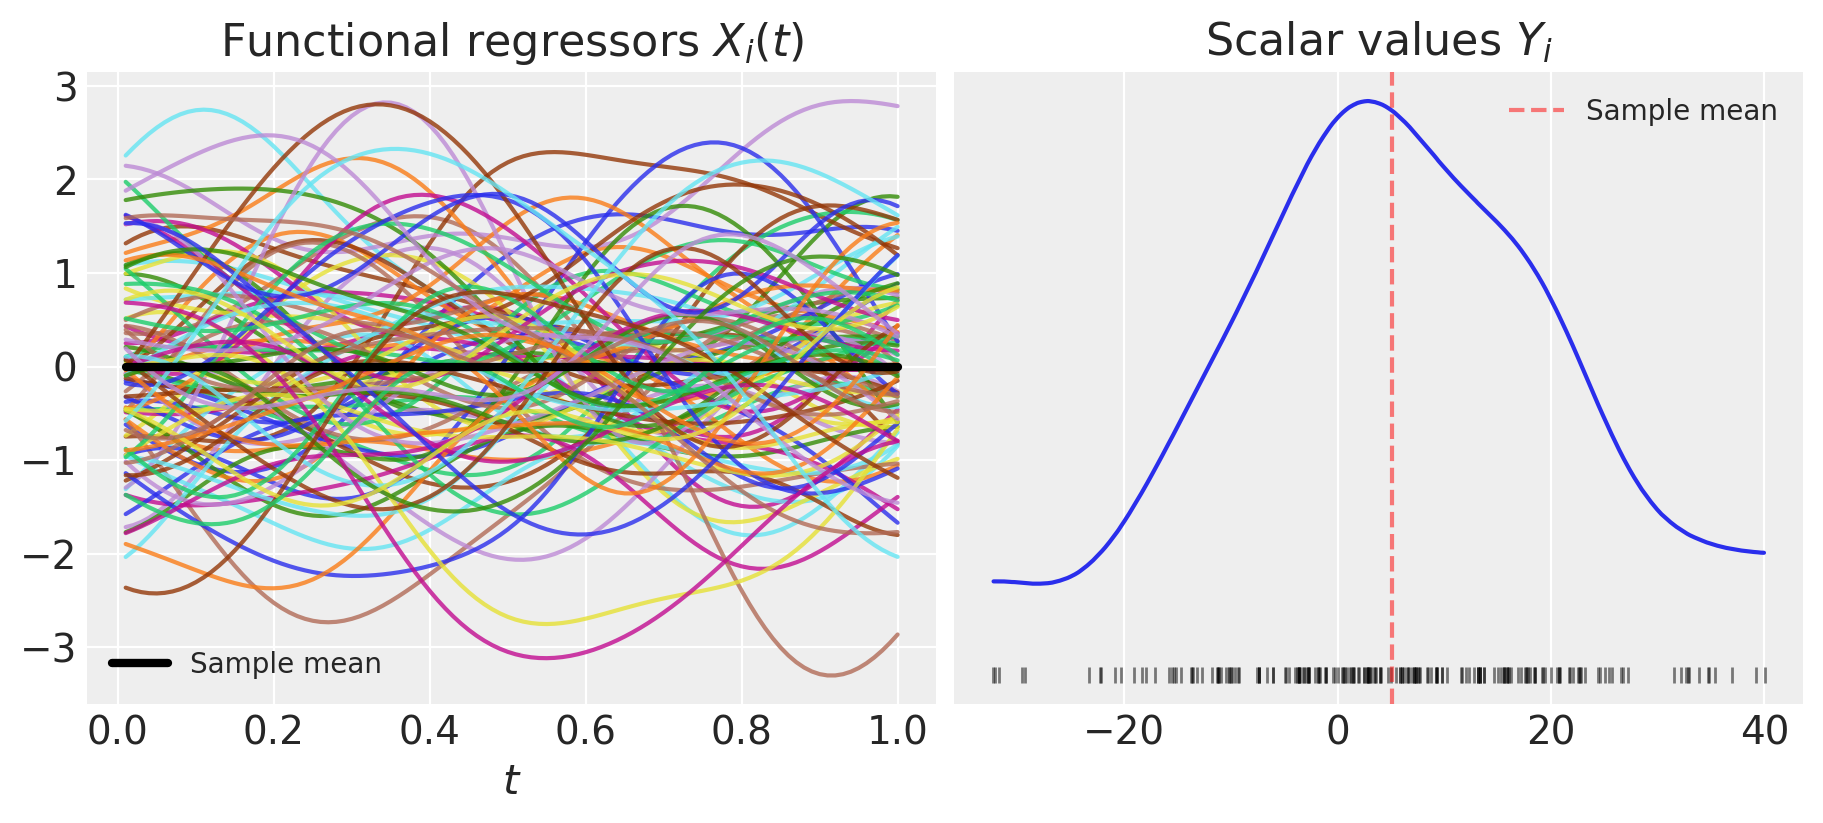

In [43]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    grid,
    n_samples=n_samples // 3,
)

## Bayesian model

In [44]:
# -- Bayesian model parameters

TRANSFORM_SIGMA = True
RELABEL_STRATEGY = "auto"  # beta, tau or auto
THETA_SPACE = ThetaSpace(
    grid,
    names=["b", "t", "alpha0", "sigma2"],
    idx=[0, 1, 0, 1],
    transform_sigma=TRANSFORM_SIGMA,
)
SD_PRIOR_BETA = 5
MIN_DIST_TAU = 1
LAMBDA_P = None  # None means uniform prior

### Prior

In [45]:
# -- Prior distributions

priors_simple = {
    "all_models_together": RKHSPriorLinear(
        THETA_SPACE,
        sd_beta=SD_PRIOR_BETA,  # vague prior on beta; data is scaled to have SD=1
        lambda_p=LAMBDA_P,  # Only useful for the RJ move (not MT RJ)
        min_dist_tau=MIN_DIST_TAU,  # impose |t_i - t_j| > minimum_distance_tau
    )
}

### Likelihood

In [46]:
# -- Log-likelihood

ll = RKHSLikelihoodLinear(
    THETA_SPACE,
    X_scaled,
    Y_scaled,
)

## Sampler

### Initial values

In [83]:
# -- Set reasonable initial values for all chains

branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 10

nsteps = 500
thin_by = 1
burn = 500

# number of cores
njobs = 4
vectorize = True

coords, inds = chain_utils.setup_initial_coords_and_inds(
    ntemps,
    nwalkers,
    nleaves_max,
    ndims,
    THETA_SPACE,
    priors_simple["all_models_together"],
    Y,  # not scaled
    Y_std_orig,
    SEED
)

## Experiments

In [98]:
# -- Set up moves
# IMPORTANT: moves, update and Likelihood objects must be re-created before sampling again

NUM_TRY = 2

# In-model move for alpha0 and sigma2
move_stretch = StretchMove(gibbs_sampling_setup="common", a=2)

# Sample all parameters leaf by leaf in the components branch (currently unused)
gibbs_sampling_setup_group = [
    (
        "components",
        np.zeros((nleaves_max["components"], ndims["components"]), dtype=bool),
    )
    for _ in range(nleaves_max["components"])
]
for i in range(nleaves_max["components"]):
    gibbs_sampling_setup_group[i][-1][i] = True

# In-model move for b and t
move_group = GroupMoveRKHS(
    THETA_SPACE,
    dist_measure="beta",
    nfriends=nwalkers,
    n_iter_update=100,
    gibbs_sampling_setup="components",  # gibbs_sampling_setup_group,
    a=2,
)

# MT RJ move: generate from prior
rjmoveMTRKHS = MTRJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
    num_try=NUM_TRY,
)

# RJ move: generate from prior
rjmoveRKHS = RJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
)

# update function for the parameter 'a' in the in-model moves
update_fn_group = AdjustStretchScaleCombineMove(
    idx_moves=[0, 1],
    target_acceptance=0.3,
    max_factor=0.1,
    supression_factor=0.1,
    min_a=1.1,
)
update_iters = 50

# -- Posterior sampling with Eryn (RJMCMC)

# re-set random seed for reproducible sampling
np.random.seed(SEED)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors_simple,
        pool=pool if not vectorize else None,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=CombineMove([move_group, move_stretch]),
        rj_moves=rjmoveMTRKHS if LAMBDA_P is None and NUM_TRY > 1 else rjmoveRKHS,
        update_fn=update_fn_group,
        update_iterations=update_iters,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print(f"Sampling posterior distribution (transform_sigma={TRANSFORM_SIGMA})...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

Sampling posterior distribution (transform_sigma=True)...


100%|██████████| 500/500 [00:07<00:00, 63.33it/s]


In [92]:
# -- Post-process the cold chain only

# 1. Get full chain, with shape (nsteps, nwalkers, nleaves_max, ndim) and corresponding indices
(
    full_chain_components,
    full_chain_common,
    inds_components_post,
    inds_common_post,
    idx_order,
) = chain_utils.get_full_chain_at_T(
    ensemble,
    THETA_SPACE,
    X_std_orig,
    Y_std_orig,
    T=0,
    relabel_strategy=RELABEL_STRATEGY,
)

# 2. Get values of leaves (number of components) accross the chain
nleaves_all_T = ensemble.get_nleaves()["components"]
nleaves = nleaves_all_T[:, 0, ...]  # T=0

# Print sampling information
chain_utils.print_sampling_information(
    full_chain_components,
    full_chain_common,
    THETA_SPACE,
    ensemble,
    idx_order,
    thin_by,
    num_try=NUM_TRY,
    display_notebook=True,
)

* Last sample (T=0, W=0):


$b$     $t$
0 -8.2395  0.1153
1  2.1554  0.1366
2  1.0445  0.2555
3  8.0032  0.6590
4  6.8395  0.8392


* Acceptance % (T=0)
[GroupMoveRKHS] [14.9  7.2 14.2 13.9 14.   9.6  8.5 20.9  9.6  6.7  8.  12.1 18.9 13.3
  9.8 15.  15.8 13.2 14.  10.3 15.  10.9 12.2 11.6  8.3  8.6  8.  11.8
 16.8 18.4  9.1  9.4]
[StretchMove] [48.1 36.6 51.8 49.7 51.6 48.8 48.1 50.3 50.5 52.3 50.4 51.  55.2 53.4
 47.2 51.6 47.2 51.6 52.8 47.2 51.6 45.4 53.9 42.  46.6 52.3 52.3 51.4
 51.9 54.9 46.4 51.6]
[MTRJMoveRKHS] [0.4 0.  0.2 1.  0.  0.  0.  0.4 0.  0.  0.6 0.  0.  0.4 0.4 0.  0.  0.4
 0.  0.6 0.  0.4 0.  0.2 0.  0.  0.4 0.  0.  0.4 0.2 0. ]

* Temperature swaps accepted %: [0.4813 0.9375 2.8563 7.6875 8.0312 9.2812 8.2188 5.1312 4.9938]

* Last values of a (parameter of the in-model moves):
[GroupMoveRKHS] a=1.10
[StretchMove] a=4.72

* Num_try (for MT jump move): 2

* Chain ordered by: tau

* Gelman-Rubin diagnostic (should be near 1) 
  <R̂>: Mean value for all parameters

  --------------
 Model: components
   T 	 <R̂>
  --------------
   0	1.00
   1	1.00
   2	1.00
   3	1.00
   4	1.00
   5	1.00
   6	1.0

### Save & load chain

In [158]:
SAVE_CHAIN = False
if SAVE_CHAIN:
    if SYNTHETIC_DATA:
        filename = (
            f"{kernel_fn.__name__ if REGRESSOR_GEN == 'GP' else 'GBM'}+{MODEL_GEN}"
        )
    else:
        filename = f"{REAL_DATA}"

    sampling_info = {
        "burn": burn,
        "thin_by": thin_by,
        "num_try": num_try if USE_MT_RJ else 1,
        "USE_MT_RJ": USE_MT_RJ,
        "TRANSFORM_SIGMA": TRANSFORM_SIGMA,
        "SD_PRIOR_BETA": SD_PRIOR_BETA,
        "RELABEL_STRATEGY": RELABEL_STRATEGY,
        "MIN_DIST_TAU": MIN_DIST_TAU,
        "LAMBDA_P": LAMBDA_P,
    }
    sampling_info_structured = np.array(
        list(sampling_info.items()), dtype=[("key", "U100"), ("value", "O")]
    )

    np.savez_compressed(
        f"results/chains/{filename}_{SEED}.npz",
        full_chain_components=full_chain_components,
        full_chain_common=full_chain_common,
        nleaves_all_T=nleaves_all_T,
        sampling_info=sampling_info_structured,
    )

In [159]:
LOAD_CHAIN = False
FILENAME_LOAD = "results/chains/brownian_kernel+RKHS_2024.npz"

if LOAD_CHAIN:
    loaded_chain = np.load(FILENAME_LOAD, allow_pickle=True)
    full_chain_components = loaded_chain["full_chain_components"]
    full_chain_common = loaded_chain["full_chain_common"]
    nleaves_all_T = loaded_chain["nleaves_all_T"]
    nleaves = nleaves_all_T[:, 0, ...]  # T=0
    sampling_info = dict(loaded_chain["sampling_info"])

    nsteps, nwalkers = full_chain_components.shape[:2]
    ntemps = nleaves_all_T.shape[1]
    nleaves_max = {"components": full_chain_components.shape[2], "common": 1}
    ndims = {
        "components": full_chain_components.shape[-1],
        "common": full_chain_common.shape[-1],
    }

    # Recover the variables stored in the sampling_info dict.
    # WARNING: This is unsafe and should be used only for testing purposes,
    # since it allows arbitrary code execution
    for key, value in sampling_info.items():
        exec(f"{key} = value")

    THETA_SPACE = ThetaSpace(
        grid,
        names=["b", "t", "alpha0", "sigma2"],
        idx=[0, 1, 0, 1],
        transform_sigma=TRANSFORM_SIGMA,
    )

## Analysis

### Flat posterior distributions (for all p)

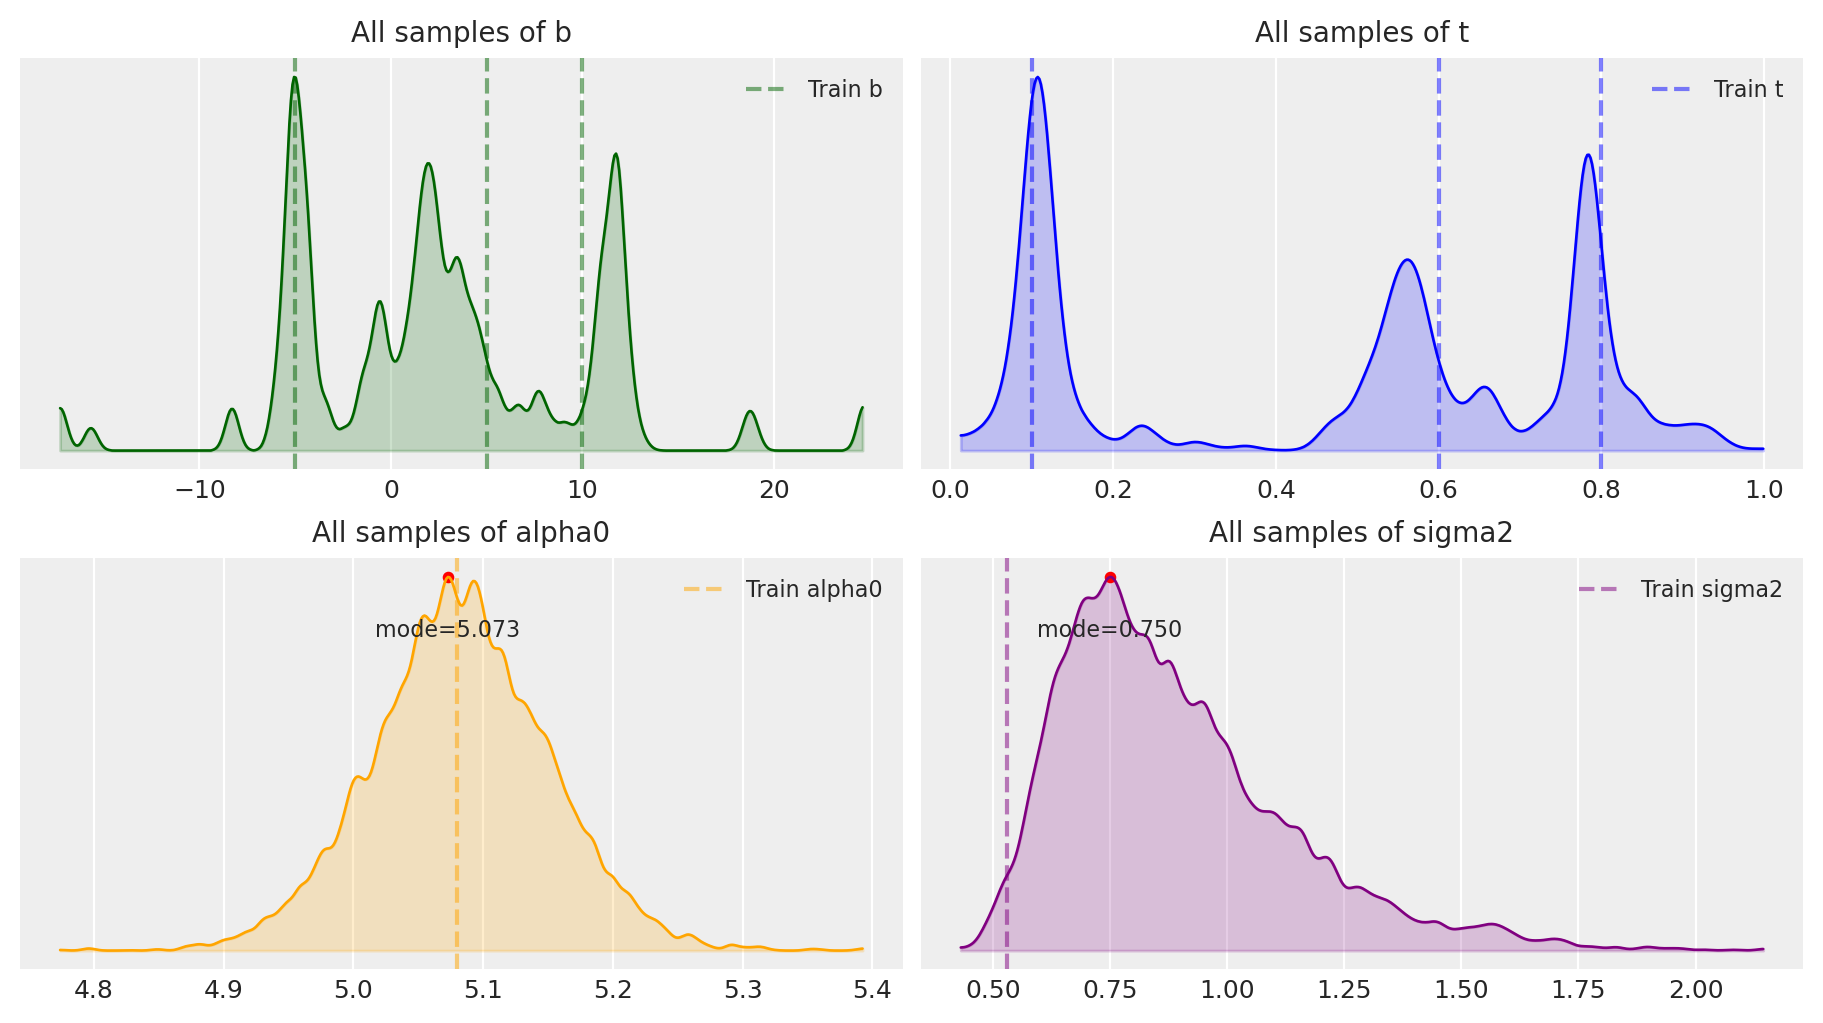

In [93]:
# Get flat chain, with shape (N, ndim), where N is the number of valid samples across all steps, walkers and leaves
flat_chain_components = chain_utils.get_flat_chain_components(
    full_chain_components, THETA_SPACE, ndims["components"]
)
flat_chain_common = full_chain_common.reshape(-1, 2)

samples_vars = [
    flat_chain_components[:, THETA_SPACE.idx_beta],
    flat_chain_components[:, THETA_SPACE.idx_tau],
    flat_chain_common[:, THETA_SPACE.idx_alpha0],
    flat_chain_common[:, THETA_SPACE.idx_sigma2],
]
if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
    ref_values = [
        beta_true,
        tau_true,
        Y.mean(),
        np.var(y[idx_train] - y_noiseless[idx_train]),
    ]
else:
    ref_values = None

plot_utils.plot_flat_posterior(samples_vars, THETA_SPACE, COLORS, ref_values)

### Trace plot for individual components (for all p)

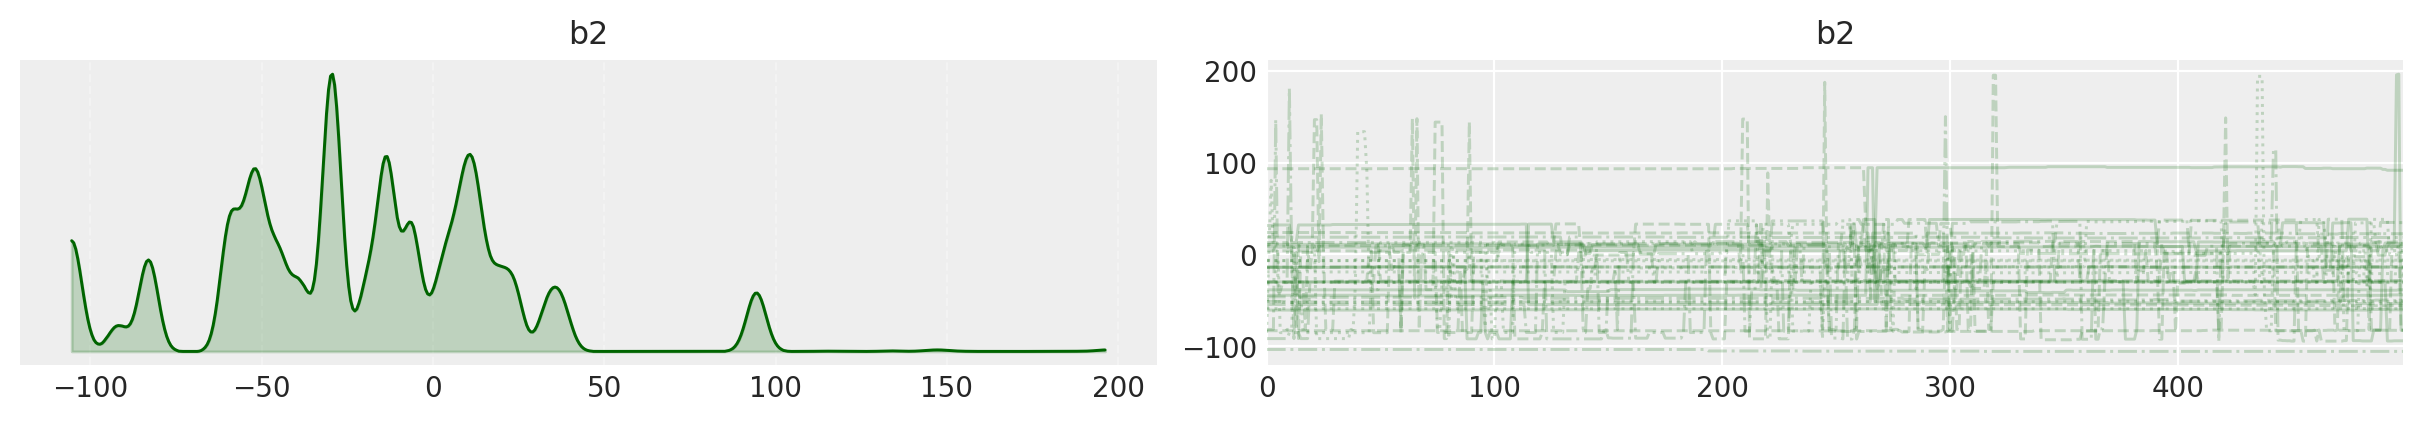

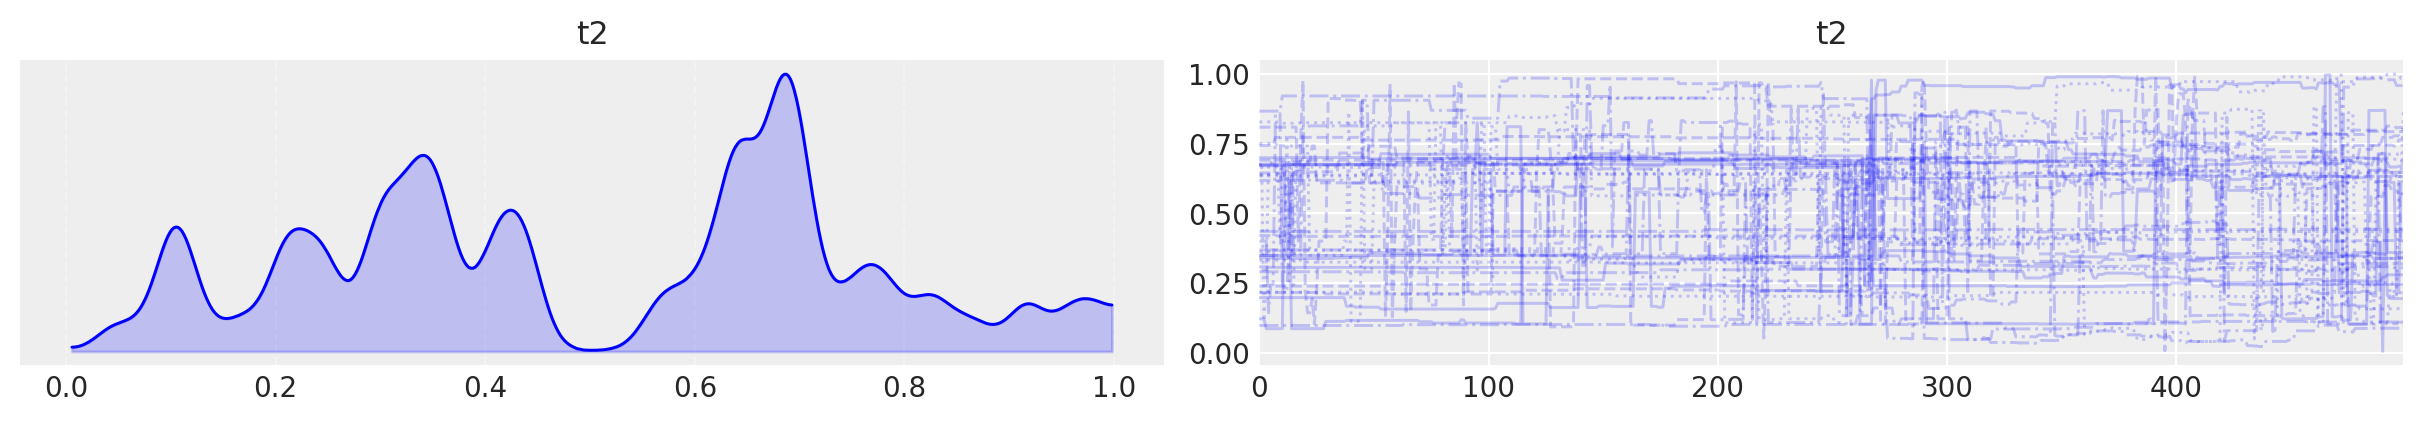

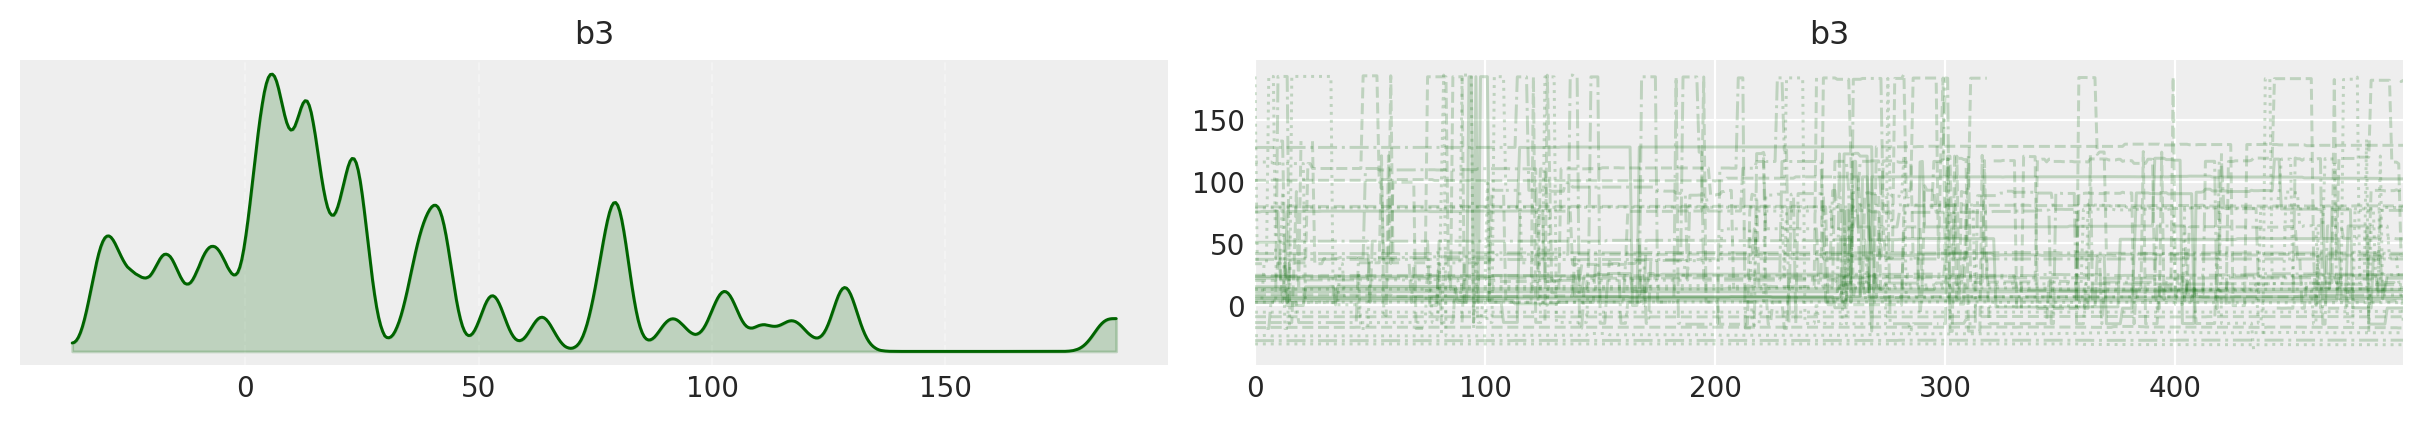

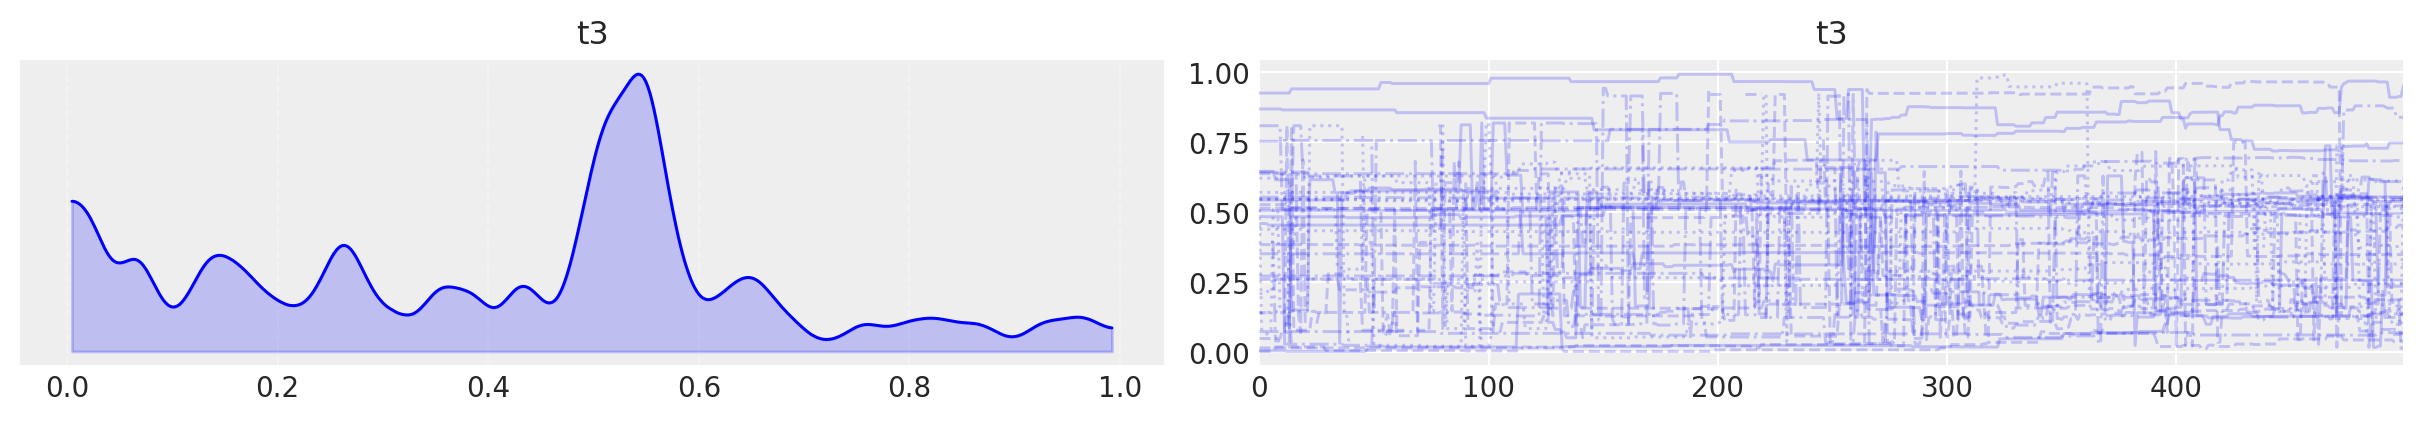

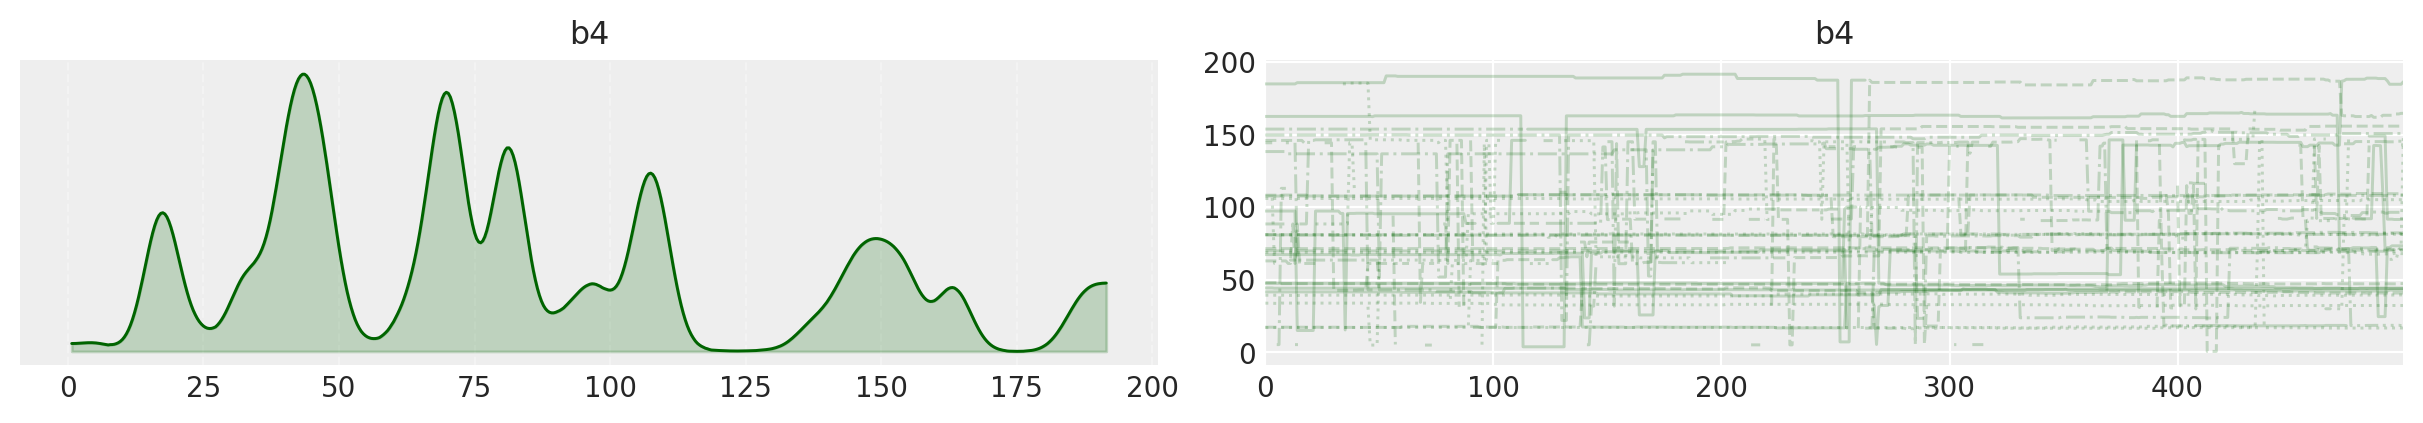

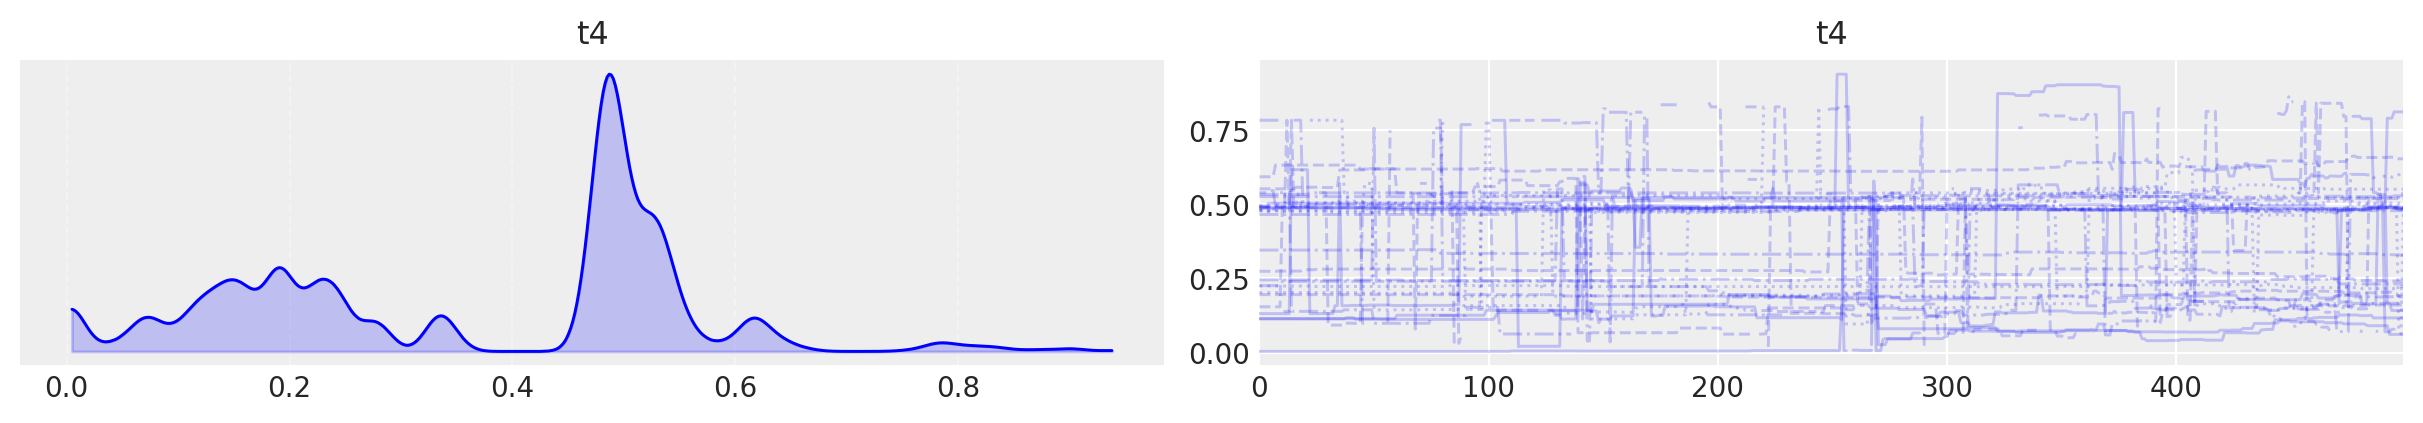

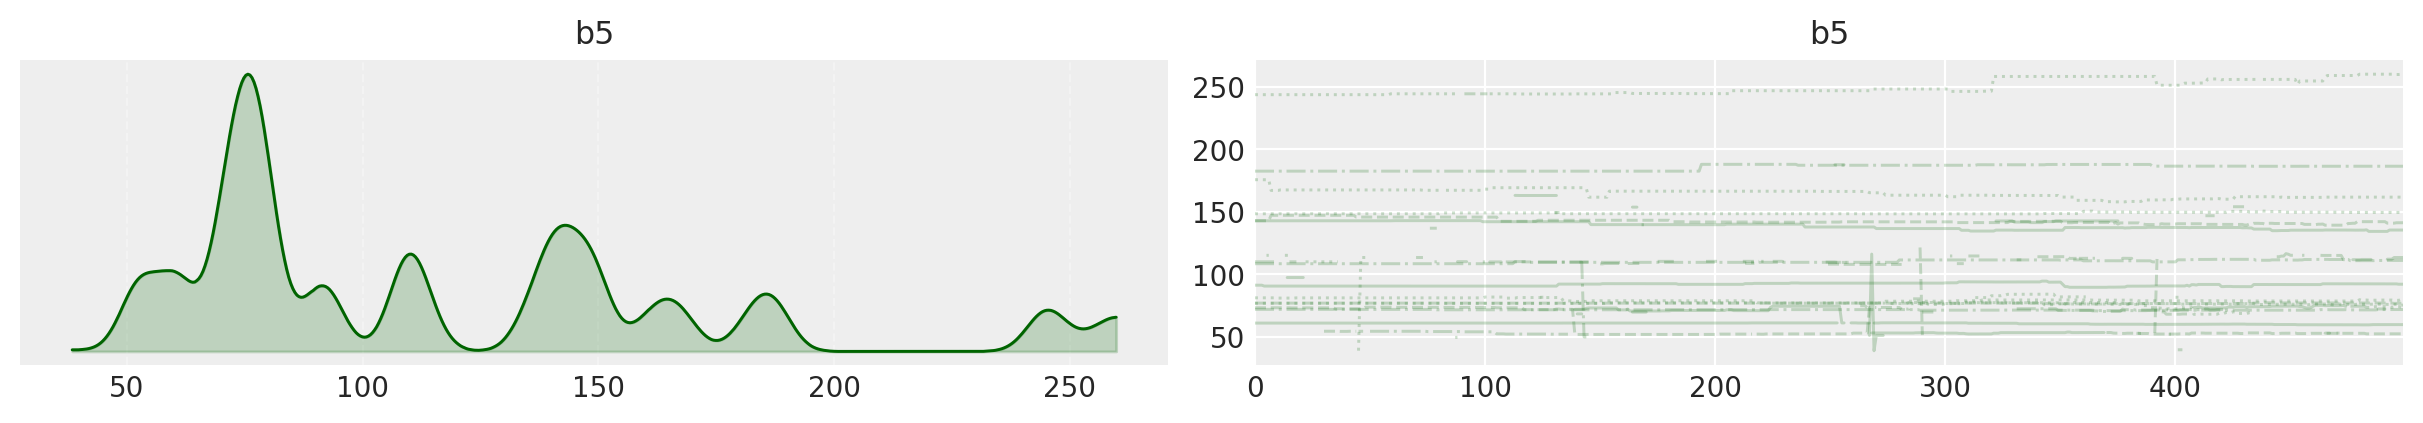

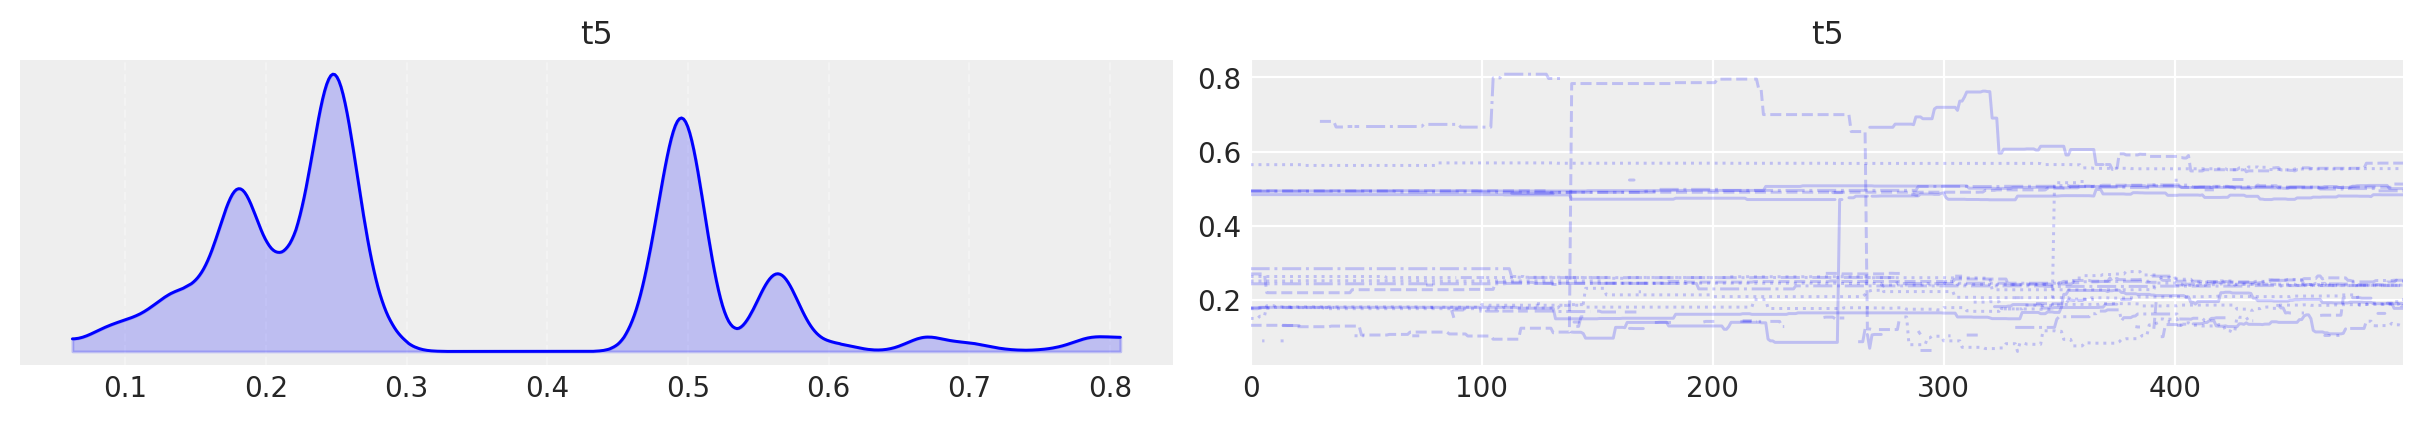

In [161]:
for component_id in range(nleaves_max["components"]):
    if ~np.any(nleaves == component_id + 1):
        continue

    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_beta],
        f"b{component_id + 1}",
        None,
        beta_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[0],
    )
    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_tau],
        f"t{component_id + 1}",
        None,
        tau_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[1],
    )

### Trace plot for $\alpha_0$ and $\sigma^2$ (for all p)

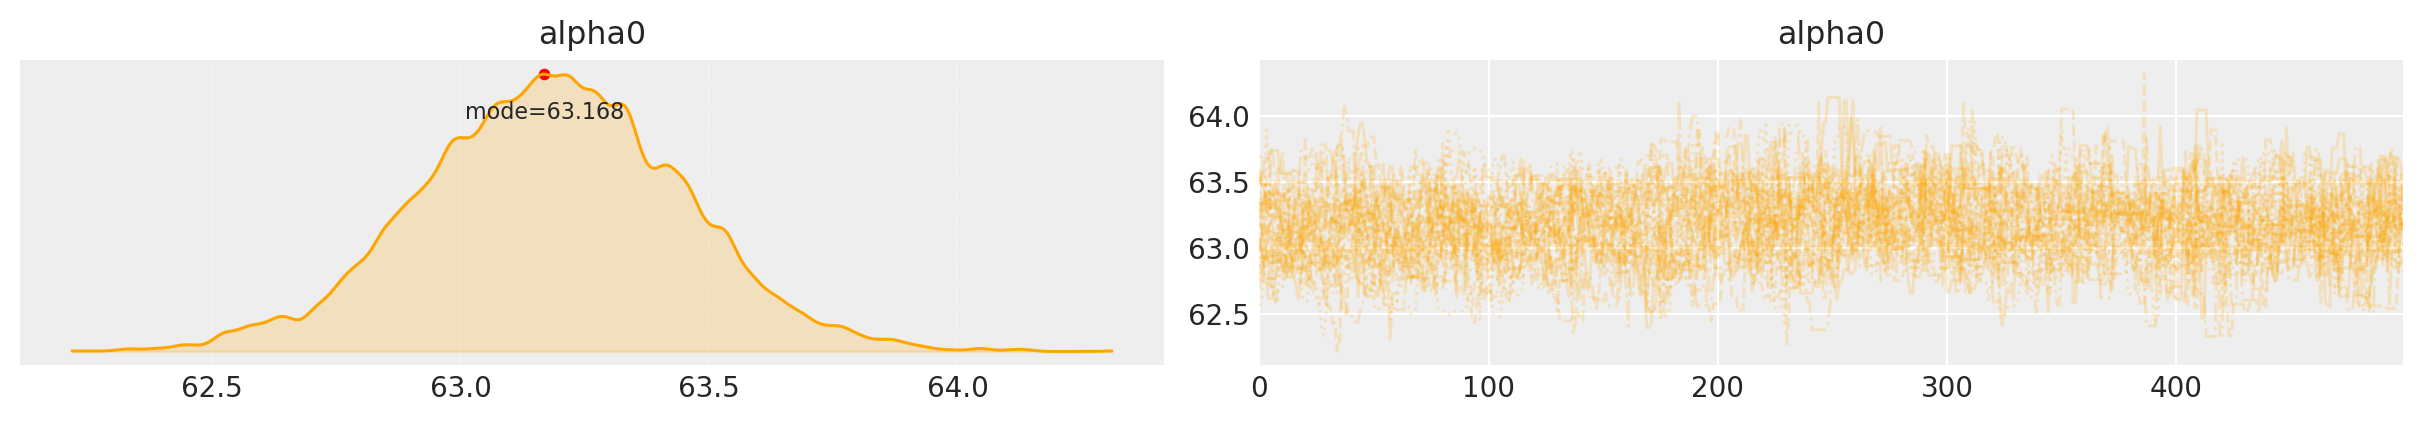

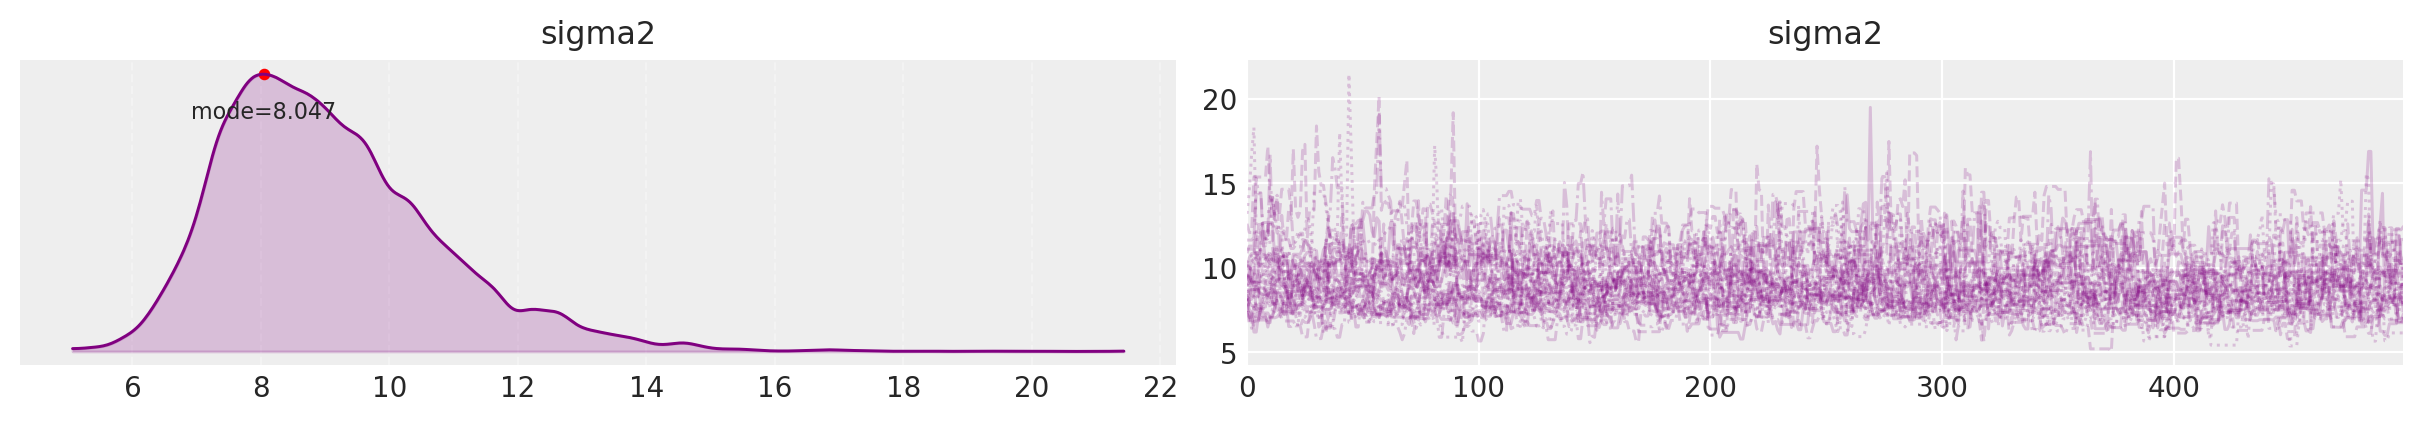

In [162]:
plot_utils.plot_trace(
    full_chain_common[..., THETA_SPACE.idx_alpha0],
    "alpha0",
    None,
    Y.mean() if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
    mode=True,
    color=COLORS[2],
)
plot_utils.plot_trace(
    full_chain_common[..., THETA_SPACE.idx_sigma2],
    "sigma2",
    None,
    np.var(y[idx_train] - y_noiseless[idx_train])
    if SYNTHETIC_DATA and MODEL_GEN == "RKHS"
    else None,
    mode=True,
    color=COLORS[3],
)

### Triangular posterior distribution of individual components (for each p)

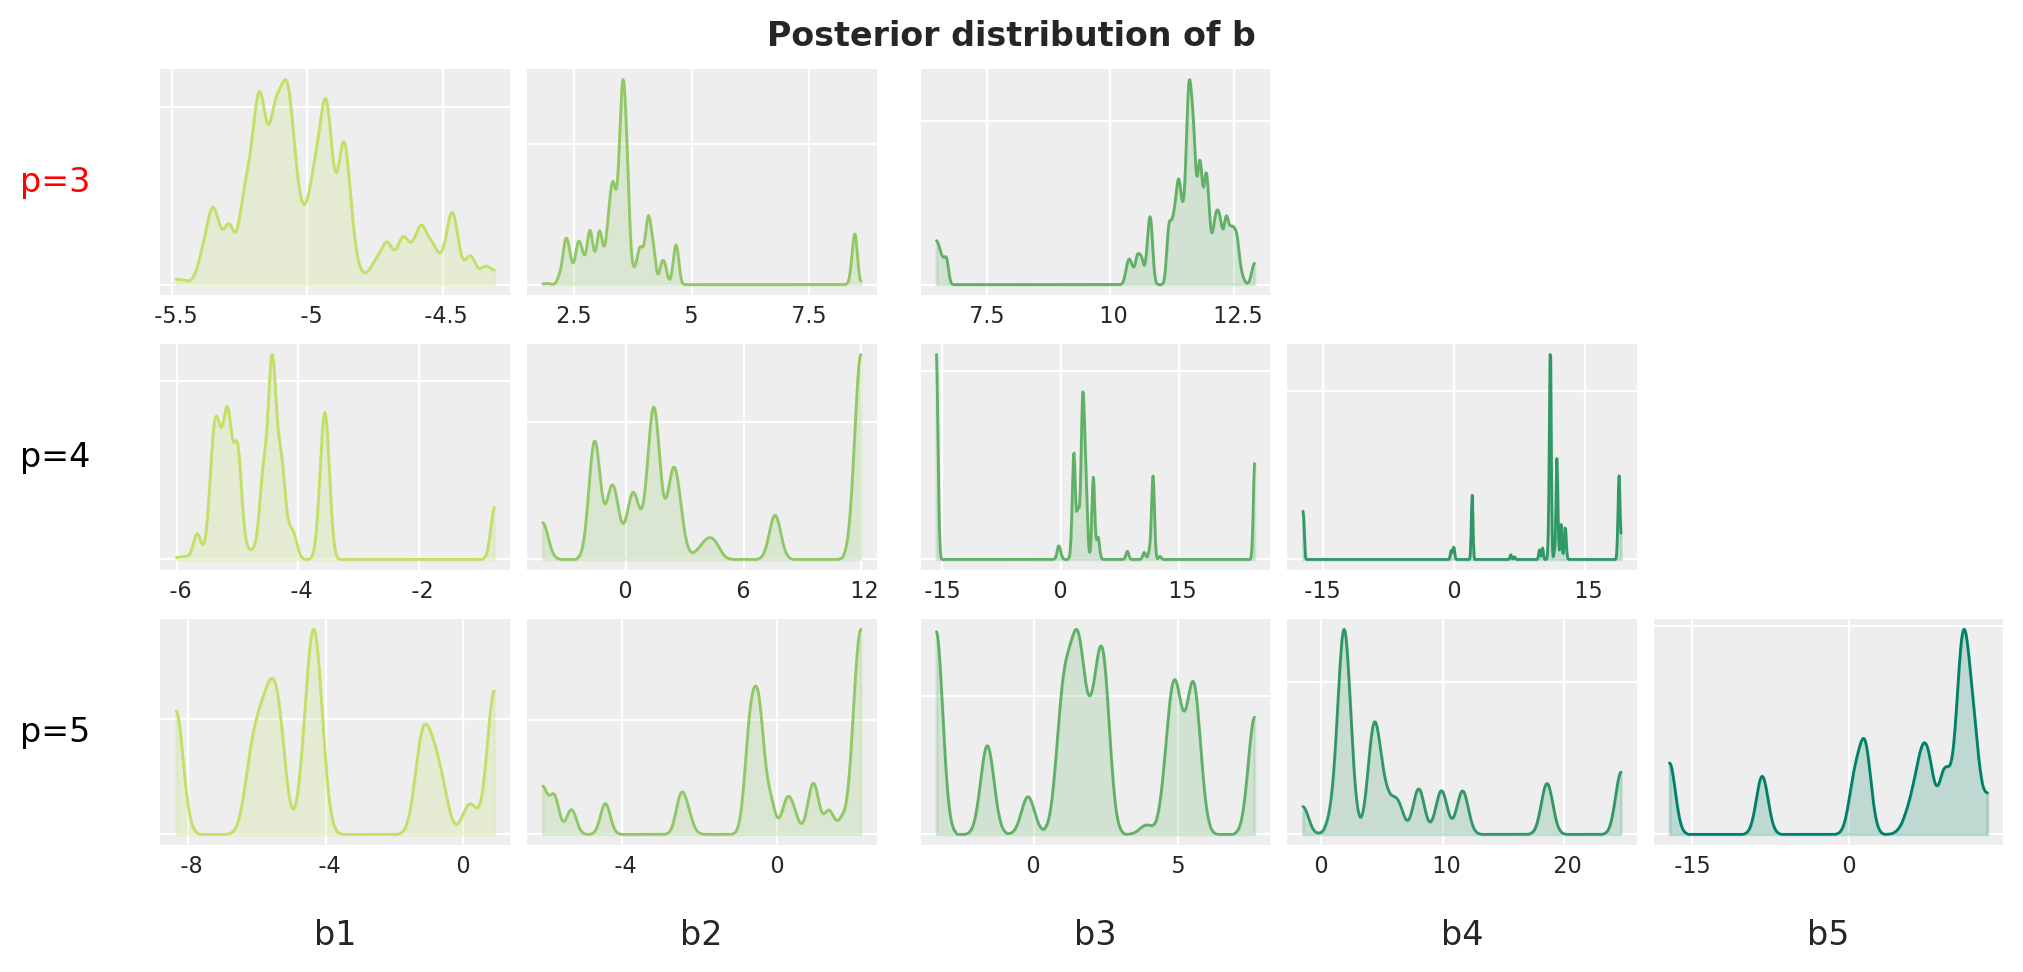

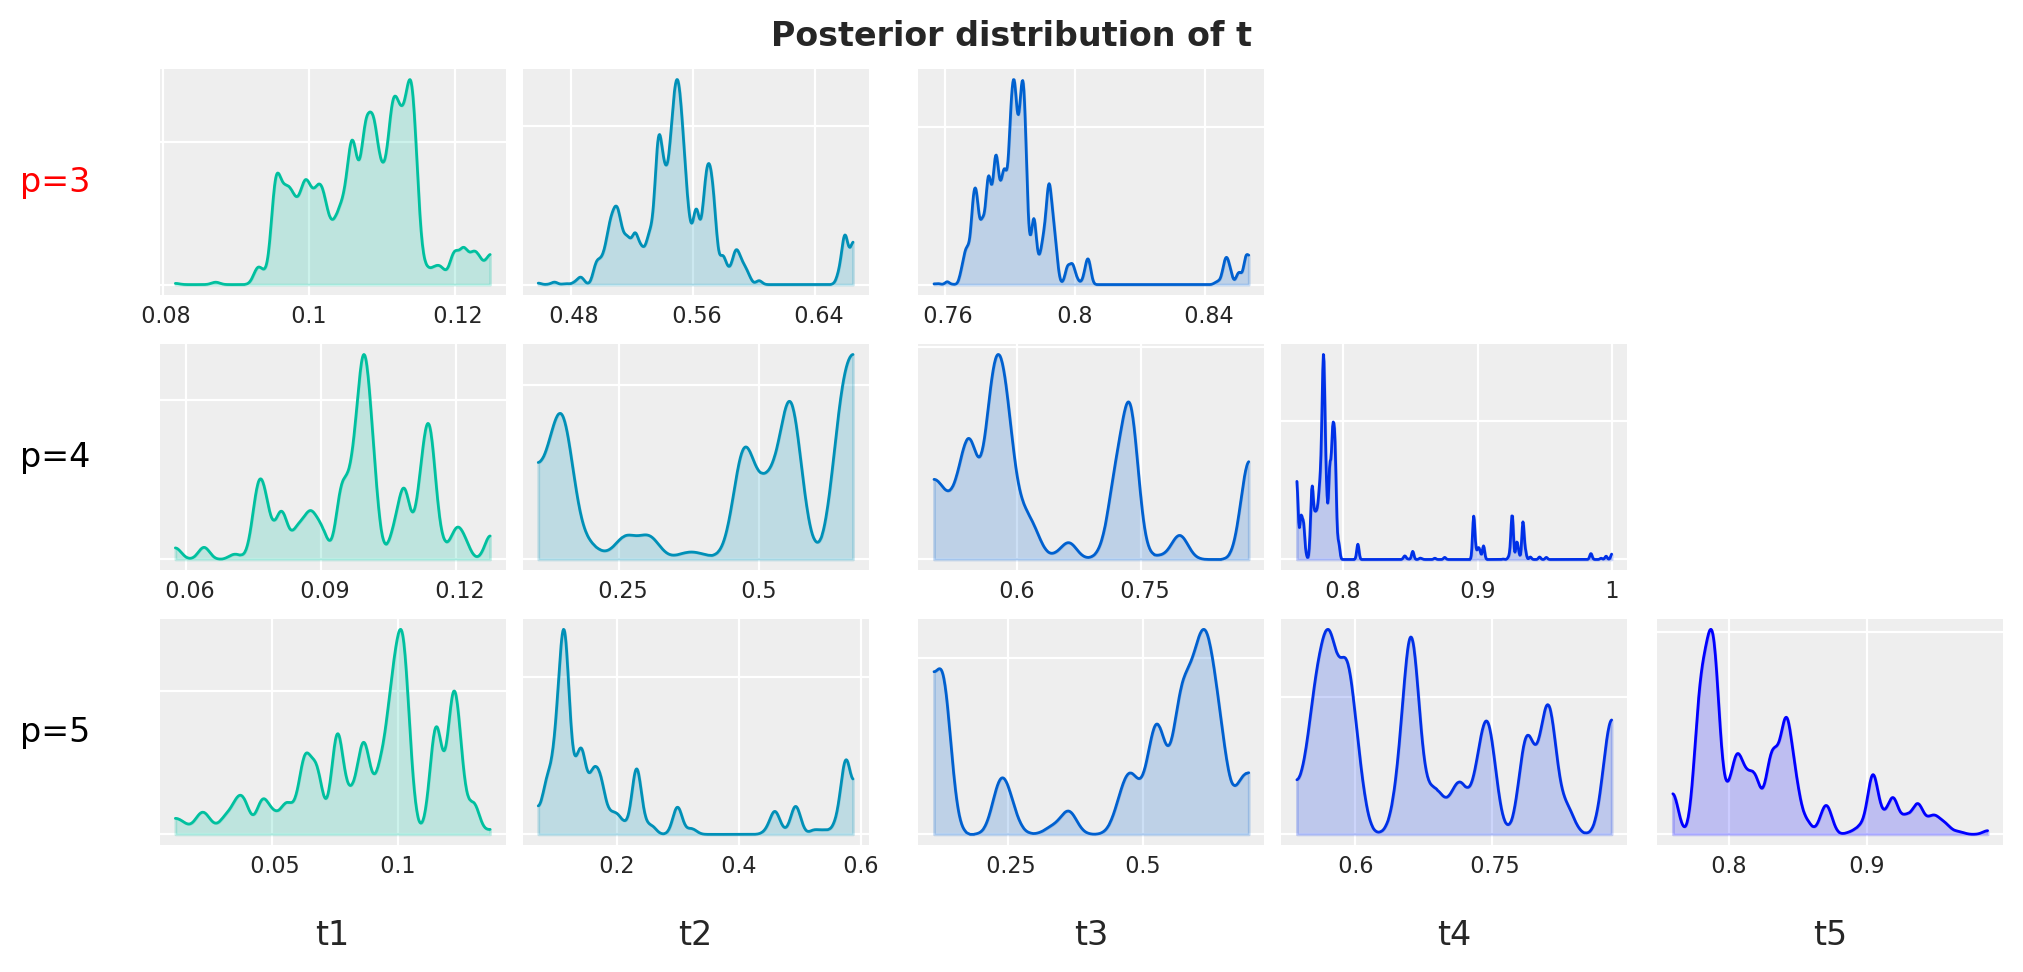

In [87]:
plot_utils.triangular_plot_components(
    full_chain_components,
    nleaves,
    THETA_SPACE.idx_beta,
    "b",
    plt.get_cmap("summer"),
    COLORS[4],
)
plot_utils.triangular_plot_components(
    full_chain_components,
    nleaves,
    THETA_SPACE.idx_tau,
    "t",
    plt.get_cmap("winter"),
    COLORS[4],
)

### Posterior distribution of $\alpha_0$ and $\sigma^2$ (for each p)

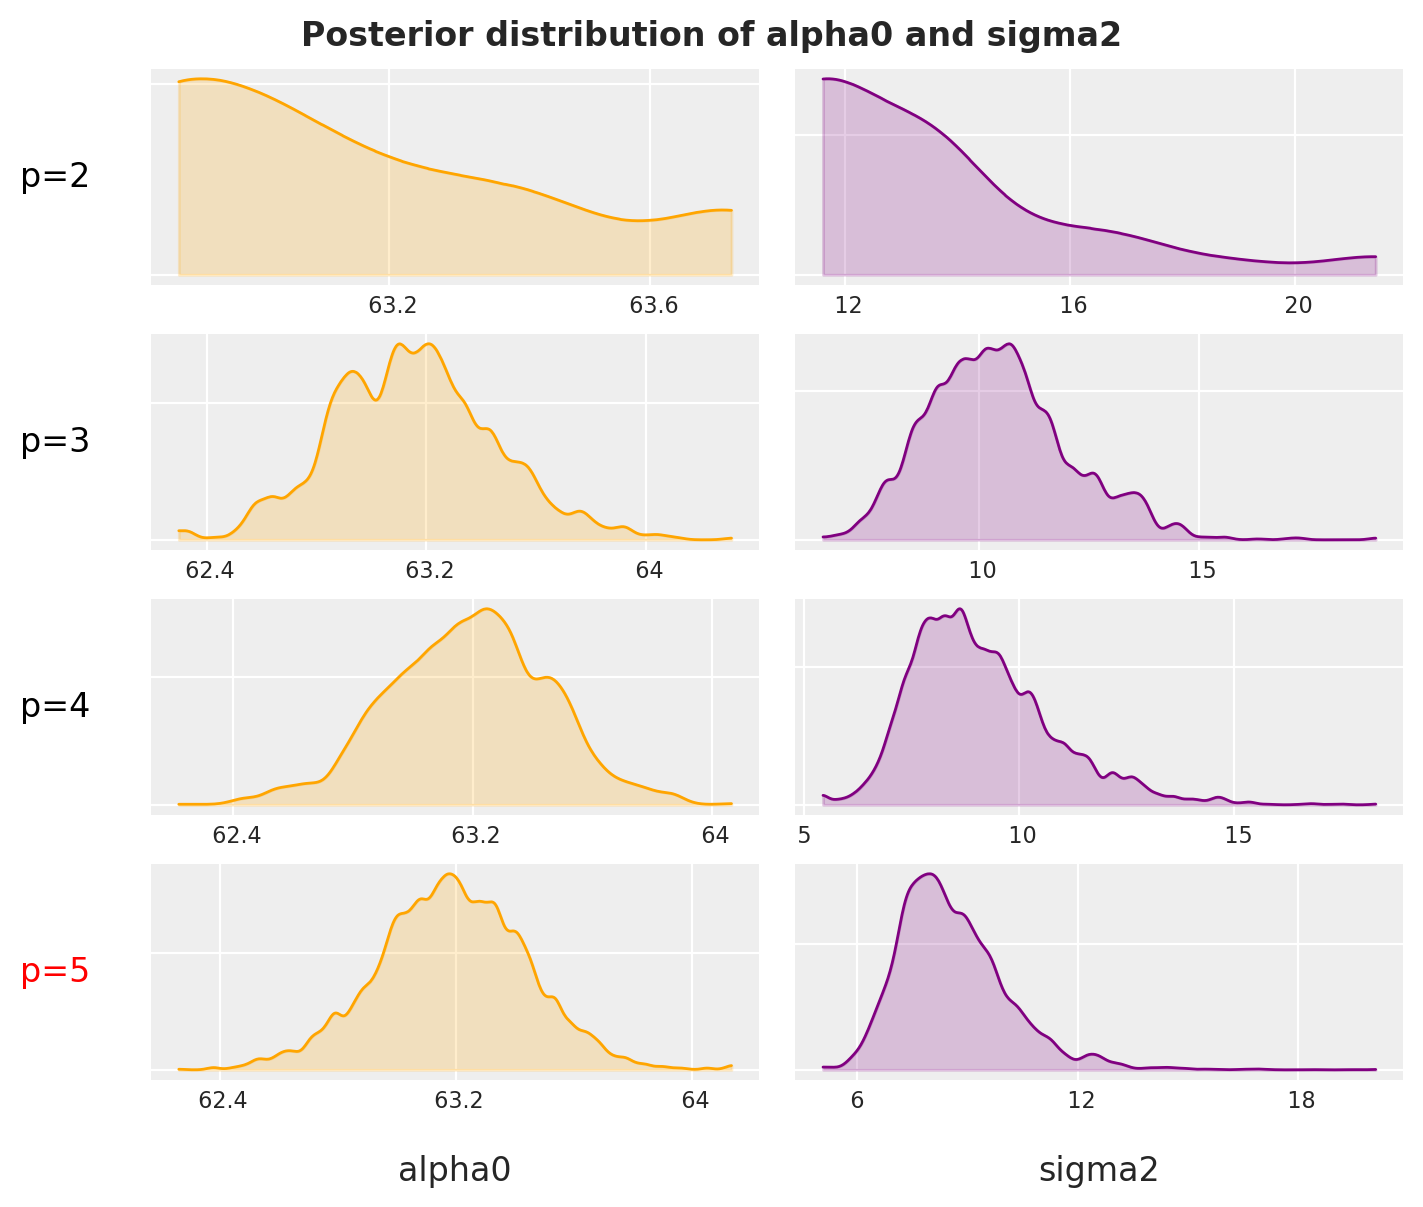

In [164]:
plot_utils.posterior_plot_common(
    full_chain_common, nleaves, THETA_SPACE.idx_alpha0, COLORS[2:4], COLORS[4]
)

### Trace plot for p

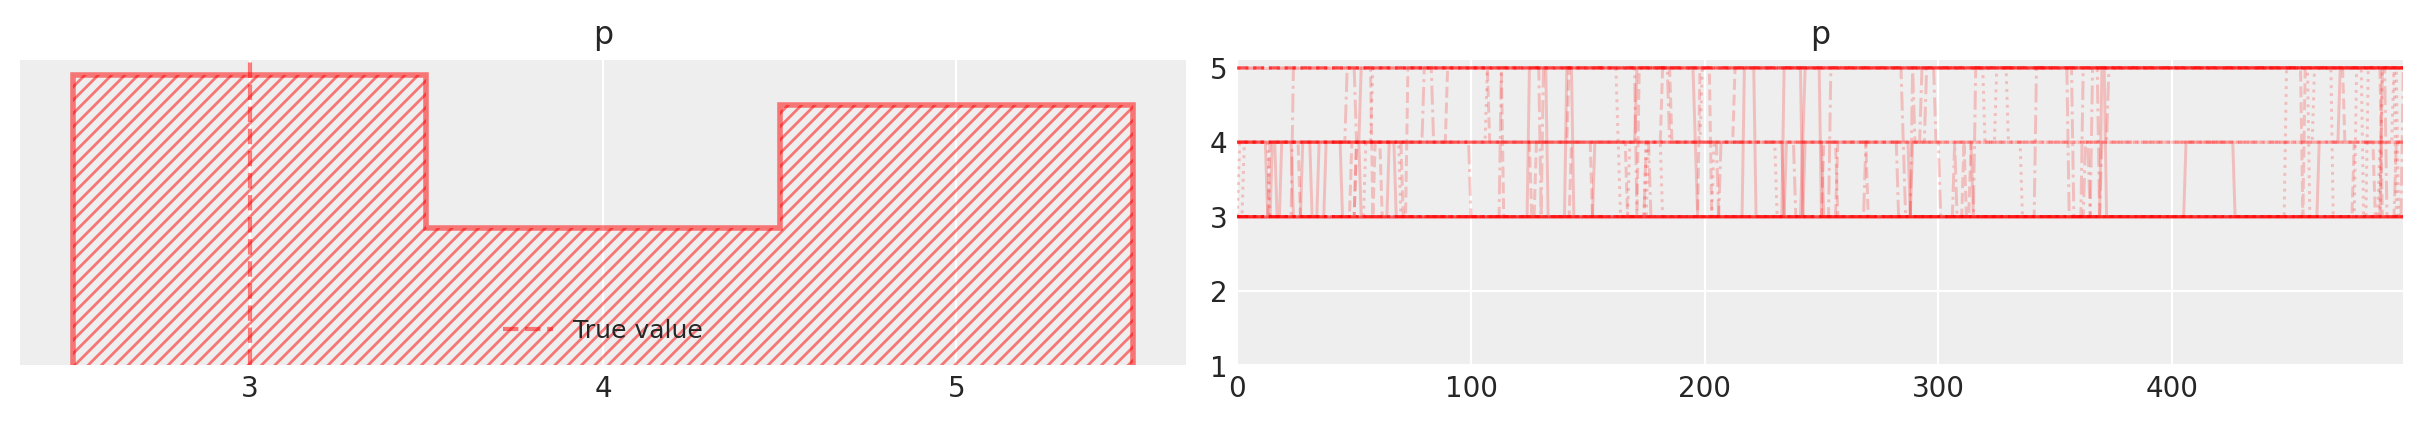

In [94]:
plot_utils.plot_trace_p(
    nleaves,
    nleaves_max["components"],
    COLORS[4],
    p_true=len(beta_true) if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
)

### Tempered posterior distribution of p

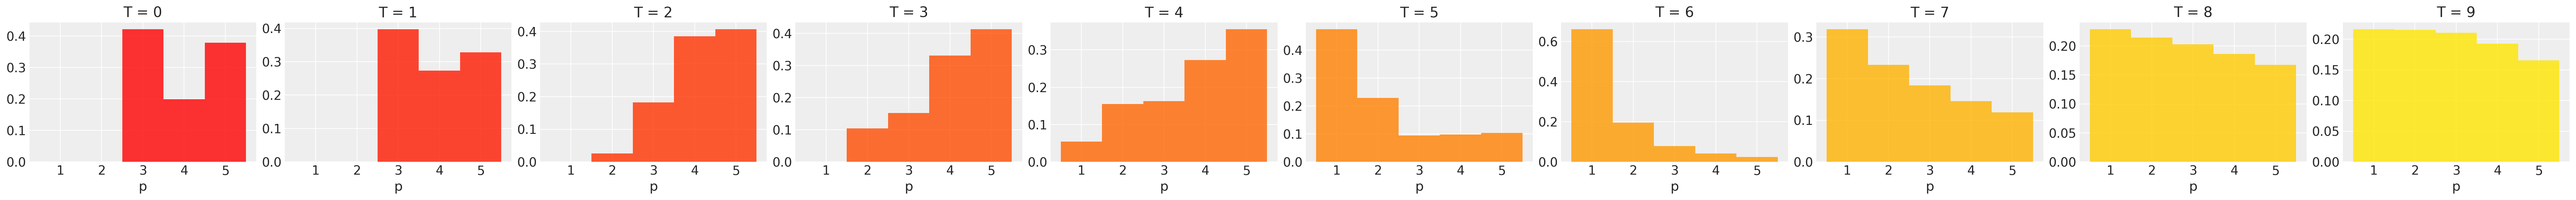

In [95]:
plot_utils.plot_tempered_posterior_p(
    ntemps, nleaves_all_T, nleaves_max["components"], plt.get_cmap("autumn")
)

### Posterior predictive plot for training data

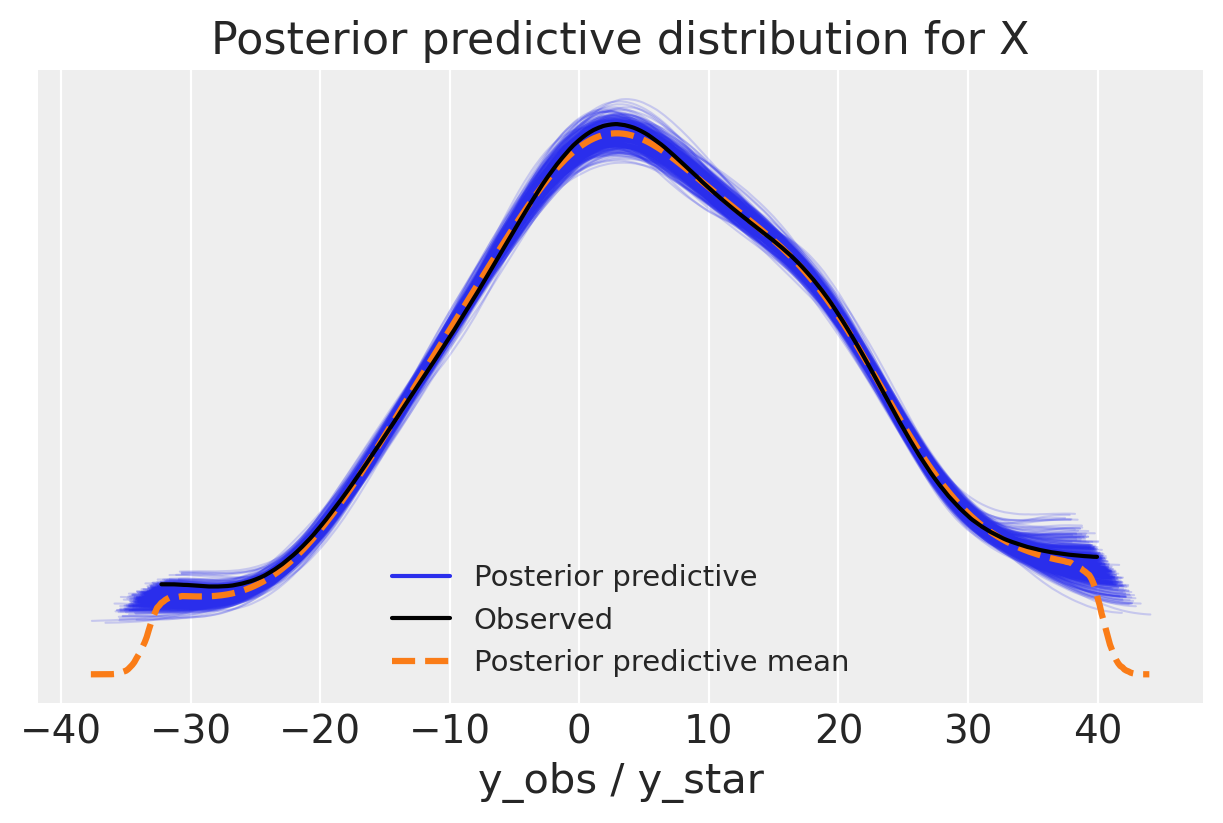

In [90]:
plot_utils.plot_ppc(
    full_chain_components, full_chain_common, THETA_SPACE, X, Y, is_test_data=False
)

## Prediction

Consider $\theta_p = (b_1,\dots, b_p, t_1,\dots, t_p, \alpha_0, \sigma^2)$ and the linear model $y\equiv F(\theta_p, p|x) = \alpha_0 + \sum_{j=1}^p b_j x(t_j)$. After a RJMCMC run on $D_n = (X,Y)$, we get $M$ samples $\{(\theta_{p_m}^m, p_m)\}$, $m=1,\dots,M$, of the corresponding posterior distribution $\pi(\theta_p, p | D)$ (the samples of all walkers are aggregated together, so $M=\texttt{nsteps}\times \texttt{nwalkers}$). We want to predict the label $y^*$ of a regressor $x^*$, using the RMSE to measure the error on each case.

- **Method 1 (PP)**: Posterior predictive distribution for all $p$. Considering a summary function $g$, such as the mean, trimmed mean (with, say, 10% of values ignored on each side) or median, the predictions are simply $g(\{F(\theta_{p_m}^m, p_m| x^*)\}_m)$. For the mean for example, we get:
$$y^* = \frac{1}{M}\sum_{m=1}^M F(\theta_{p_m}^{m}, p_m | x^*).$$
In this case we choose to disregard the noise $\sigma^2$ in the model $F()$, essentially doing an "average of the average", so to speak. However, the values of $(\sigma^2)^m$ could be included in the computations and/or used to measure the uncertainty of the predictions.

- **Method 2 (Weighted PP)**: Posterior predictive distribution for all $p$, weighted by the posterior of each p. This is based on the concept of *model averaging*: $\pi(\theta|D) = \sum_p \pi(\theta|D,p)\pi(p|D)$. Denote $M_p = \sum_{m=1}^M \mathbb{I}(p_m = p)$ and the approximation of the posterior distribution of $p$ by $\tilde\pi(p|D) = \frac{1}{M} M_p$. The predictions are:
$$y^* = \sum_{p=1}^P \tilde\pi(p|D) g(\{F(\theta_{p}^m, p | x^*)\}_{m:p_m=p}).$$
Particularizing for the mean, we get the same result as Method 1 above:
$$y^* = \sum_{p=1}^P \tilde\pi(p|D) \frac{1}{M_p}\sum_{m:\ p_m = p} F(\theta_{p}^m, p | x^*) = \frac{1}{M}\sum_{p=1}^P\sum_{m:\ p_m = p} F(\theta_{p}^m, p | x^*) = \frac{1}{M}\sum_{m=1}^M F(\theta_{p_m}^{m}, p_m | x^*).$$

- **Method 3 (MAP PP)**: Same as Method 1, but first condition on the most probable posterior value of $p$, then use the posterior predictive distribution for that value of $p$. Define $\hat p = \max_p M_p$ and compute the predictions as $g(\{F(\theta_{p_m}^m, p_m| x^*)\}_{m:p_m=\hat p})$. For example, for the mean:
$$y^* = \frac{1}{M_{\hat p}}\sum_{m:\ p_m = \hat p} F(\theta_{\hat p}^{m}, \hat p | x^*).$$
If there is more than one mode, always consider the smallest one.

- **Method 4 (Weighted summary)**: Similar to Method 2, but instead of using the PP for predictions, compute a single point summary statistic $T$ of all values in $\theta_p$ for each $p$ (minus the error variance $\sigma^2$), and use them as inputs to $F()$. Consider the mean, trimmed mean, median and mode as summaries. In this case, $T$ plays the part the aggregating function $g()$. The predictions are:
$$y*= \sum_{p=1}^P \tilde\pi(p|D) F(T\{\theta_p^m\}_{m:p_m=p}, p|x*)$$
Note that in this case the parameter $\sigma^2$ is treated as a nuisance parameter and thus ignored in the final predictions.

- **Method 5 (MAP summary)**: Same as Method 3, but compute a summary of each value of $\theta_{\hat p}$ and use them as inputs to $F()$.

- **Method 6 (Weighted variable selection)**: Same as Method 4, but instead of using the summaries of $\theta$ as input to $F()$, use *only* the summaries of $t$ to reduce the original dataset to a finite-dimensional one (for each $p$). Then apply a finite-dimensional regression method for each of the $p$ reduced data sets, and combine the responses by the weight of the posterior of $p$.
  
- **Method 7 (MAP variable selection)**: Same as Method 5, but instead of using the summaries of $\theta$ as input to $F()$, use them to reduce the original dataset to a finite-dimensional one with $\hat p$ features. Then apply a finite-dimensional regression method.

In [168]:
FIT_SK = True
RUN_SUMMARY_METHODS = False

SUMMARY_STATISTICS = [
    np.mean,
    lambda x, axis: trim_mean(x, 0.1),
    np.median,
    lambda x, axis: np.apply_along_axis(utility.mode_kde, axis=axis, arr=x),
]

DF_COLUMNS = ["Estimator", "Features", "Noise", "RMSE", "rRMSE"]
SORT_BY = -2
FOLDS = KFold(n_splits=5, shuffle=True, random_state=SEED)

max_used_p = np.max(np.unique(nleaves))

### Reference methods

In [169]:
# -- Fit reference models and show metrics

if FIT_SK:
    regressors = run_utils.get_reference_models_linear(nleaves_max["components"], SEED)
    
    df_reference, reg_cv = run_utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        FOLDS,
        kind="linear",
        n_jobs=-1,
        column_names=[col for col in DF_COLUMNS if col != "Noise"],
        sort_by=SORT_BY,
        verbose=False,
    )
    print("-- All methods --")
    display(
        df_reference.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [170]:
if FIT_SK:
    df_reference_one = df_reference[~df_reference["Estimator"].str.contains("\\+")]
    print("-- One-stage methods --")
    display(
        df_reference_one.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference_one)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [171]:
if FIT_SK:
    df_reference_two = df_reference[df_reference["Estimator"].str.contains("\\+")]
    print("-- Two-stage methods --")
    display(
        df_reference_two.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference_two)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Method 1 (PP)

In [172]:
np.random.seed(SEED)

noises = [True, False]
names = ["pp_mean", "pp_tmean", "pp_median", "pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_pp(
        full_chain_components,
        full_chain_common,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    run_utils.fill_df_scores(df, Y_test, Y_pred, name, max_used_p, noise)

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = df.copy()
df.style.hide(axis="index")

### Method 2 (Weighted PP)

In [173]:
#np.random.seed(SEED)

noises = [True, False]
names = ["w_pp_mean", "w_pp_tmean", "w_pp_median", "w_pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_weighted_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    run_utils.fill_df_scores(df, Y_test, Y_pred, name, max_used_p, noise)

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 3 (MAP PP)

In [174]:
#np.random.seed(SEED)

noises = [True, False]
names = ["map_pp_mean", "map_pp_tmean", "map_pp_median", "map_pp_mode"]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_map_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    run_utils.fill_df_scores(df, Y_test, Y_pred, name, map_p, noise)

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 4 (Weighted summary)

In [175]:
if RUN_SUMMARY_METHODS:
    #np.random.seed(SEED)

    names = ["mean", "tmean", "median", "mode"]
    df = pd.DataFrame(columns=DF_COLUMNS)

    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_weighted_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            THETA_SPACE,
            X_test,
            summary_statistic,
        )

        run_utils.fill_df_scores(
            df, Y_test, Y_pred, "w_summary_" + name, max_used_p, "N/A"
        )

    df.sort_values(df.columns[SORT_BY], inplace=True)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 5 (MAP summary)

In [176]:
if RUN_SUMMARY_METHODS:
    #np.random.seed(SEED)

    names = ["mean", "tmean", "median", "mode"]
    map_p = mode_discrete(nleaves, axis=None).mode
    df = pd.DataFrame(columns=DF_COLUMNS)

    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_map_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            map_p,
            THETA_SPACE,
            X_test,
            summary_statistic,
        )

        run_utils.fill_df_scores(
            df, Y_test, Y_pred, "map_summary_" + name, map_p, "N/A"
        )

    df.sort_values(df.columns[SORT_BY], inplace=True)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 6 (Weighted variable selection)

In [177]:
#np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"reg__alpha": np.logspace(-4, 4, 20)}
regs = [
    (
        "ridge",
        GridSearchCV(
            Pipeline([("reg", Ridge(random_state=SEED))]),
            params_regularizer,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (reg_name, reg) in product(
    zip(names, SUMMARY_STATISTICS), regs
):
    Y_pred = prediction.predict_weighted_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        reg,
    )

    run_utils.fill_df_scores(
        df, Y_test, Y_pred, "w_vs_" + summary_name + "+" + reg_name, max_used_p, "N/A"
    )

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 7 (MAP variable selection)

In [178]:
#np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"reg__alpha": np.logspace(-4, 4, 20)}
regs = [
    (
        "ridge",
        GridSearchCV(
            Pipeline([("reg", Ridge(random_state=SEED))]),
            params_regularizer,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (reg_name, reg) in product(
    zip(names, SUMMARY_STATISTICS), regs
):
    Y_pred = prediction.predict_map_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        reg,
    )

    run_utils.fill_df_scores(
        df, Y_test, Y_pred, "map_vs_" + summary_name + "+" + reg_name, map_p, "N/A"
    )

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

## Prediction results analysis

### Posterior predictive plot for test data

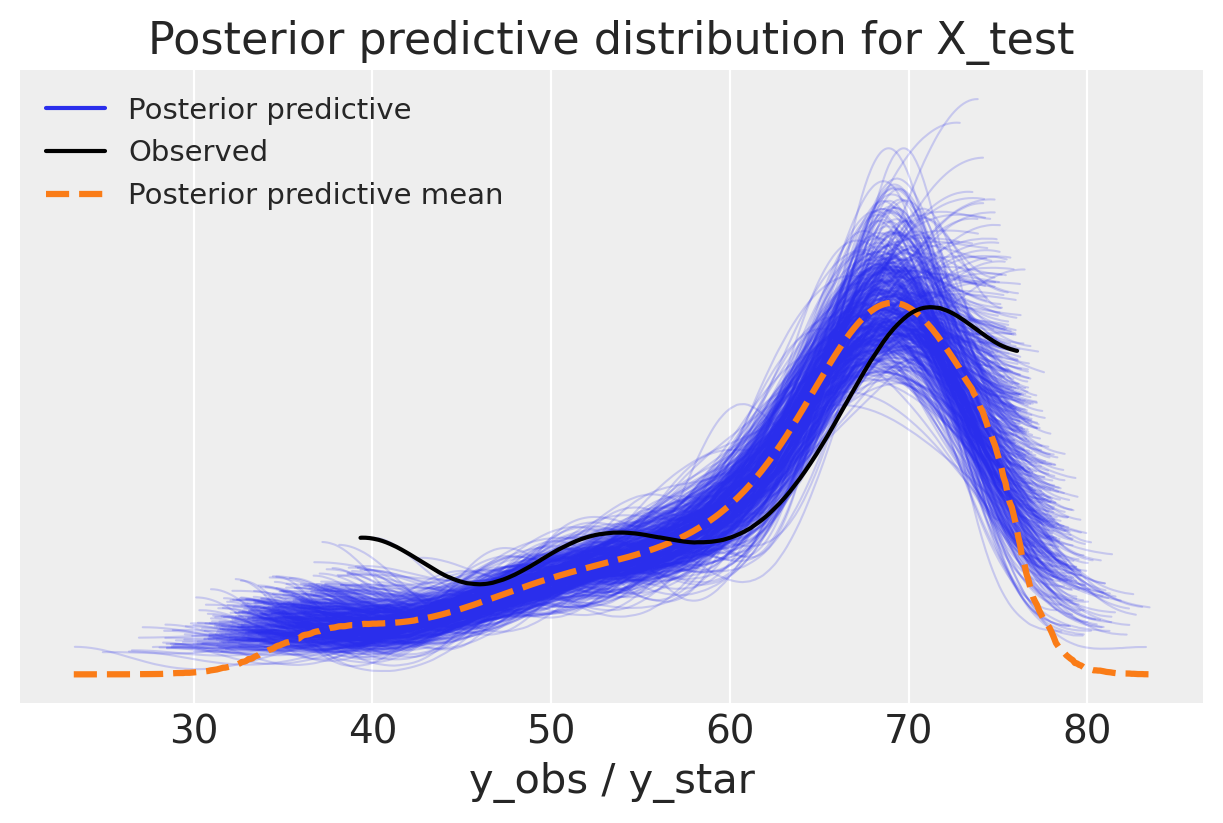

In [179]:
plot_utils.plot_ppc(
    full_chain_components,
    full_chain_common,
    THETA_SPACE,
    X_test,
    Y_test,
    is_test_data=True,
)

### Comparison of all RKHS methods

In [180]:
df_all_methods.sort_values(df_all_methods.columns[SORT_BY], inplace=True)
df_all_methods.drop_duplicates(inplace=True)
df_all_methods.style.hide(axis="index")

In [181]:
print("-- One-stage methods --")
df_all_methods_one = df_all_methods[~df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_one.style.hide(axis="index")

-- One-stage methods --


In [182]:
print("-- Two-stage methods --")
df_all_methods_two = df_all_methods[df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_two.style.hide(axis="index")

-- Two-stage methods --


### Comparison with reference methods

In [183]:
if FIT_SK:
    df_comparison_all = pd.concat([df_all_methods, df_reference], ignore_index=True)
    df_comparison_all.sort_values(df_comparison_all.columns[SORT_BY], inplace=True)
    df_comparison_all = df_comparison_all.drop_duplicates().fillna("N/A")
    print("-- All methods --")
    display(
        df_comparison_all.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [184]:
if FIT_SK:
    print("-- One-stage methods --")
    df_comparison_all_one = df_comparison_all[
        ~df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_one.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [185]:
if FIT_SK:
    print("-- Two-stage methods --")
    df_comparison_all_two = df_comparison_all[
        df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_two.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Visual comparison with reference methods

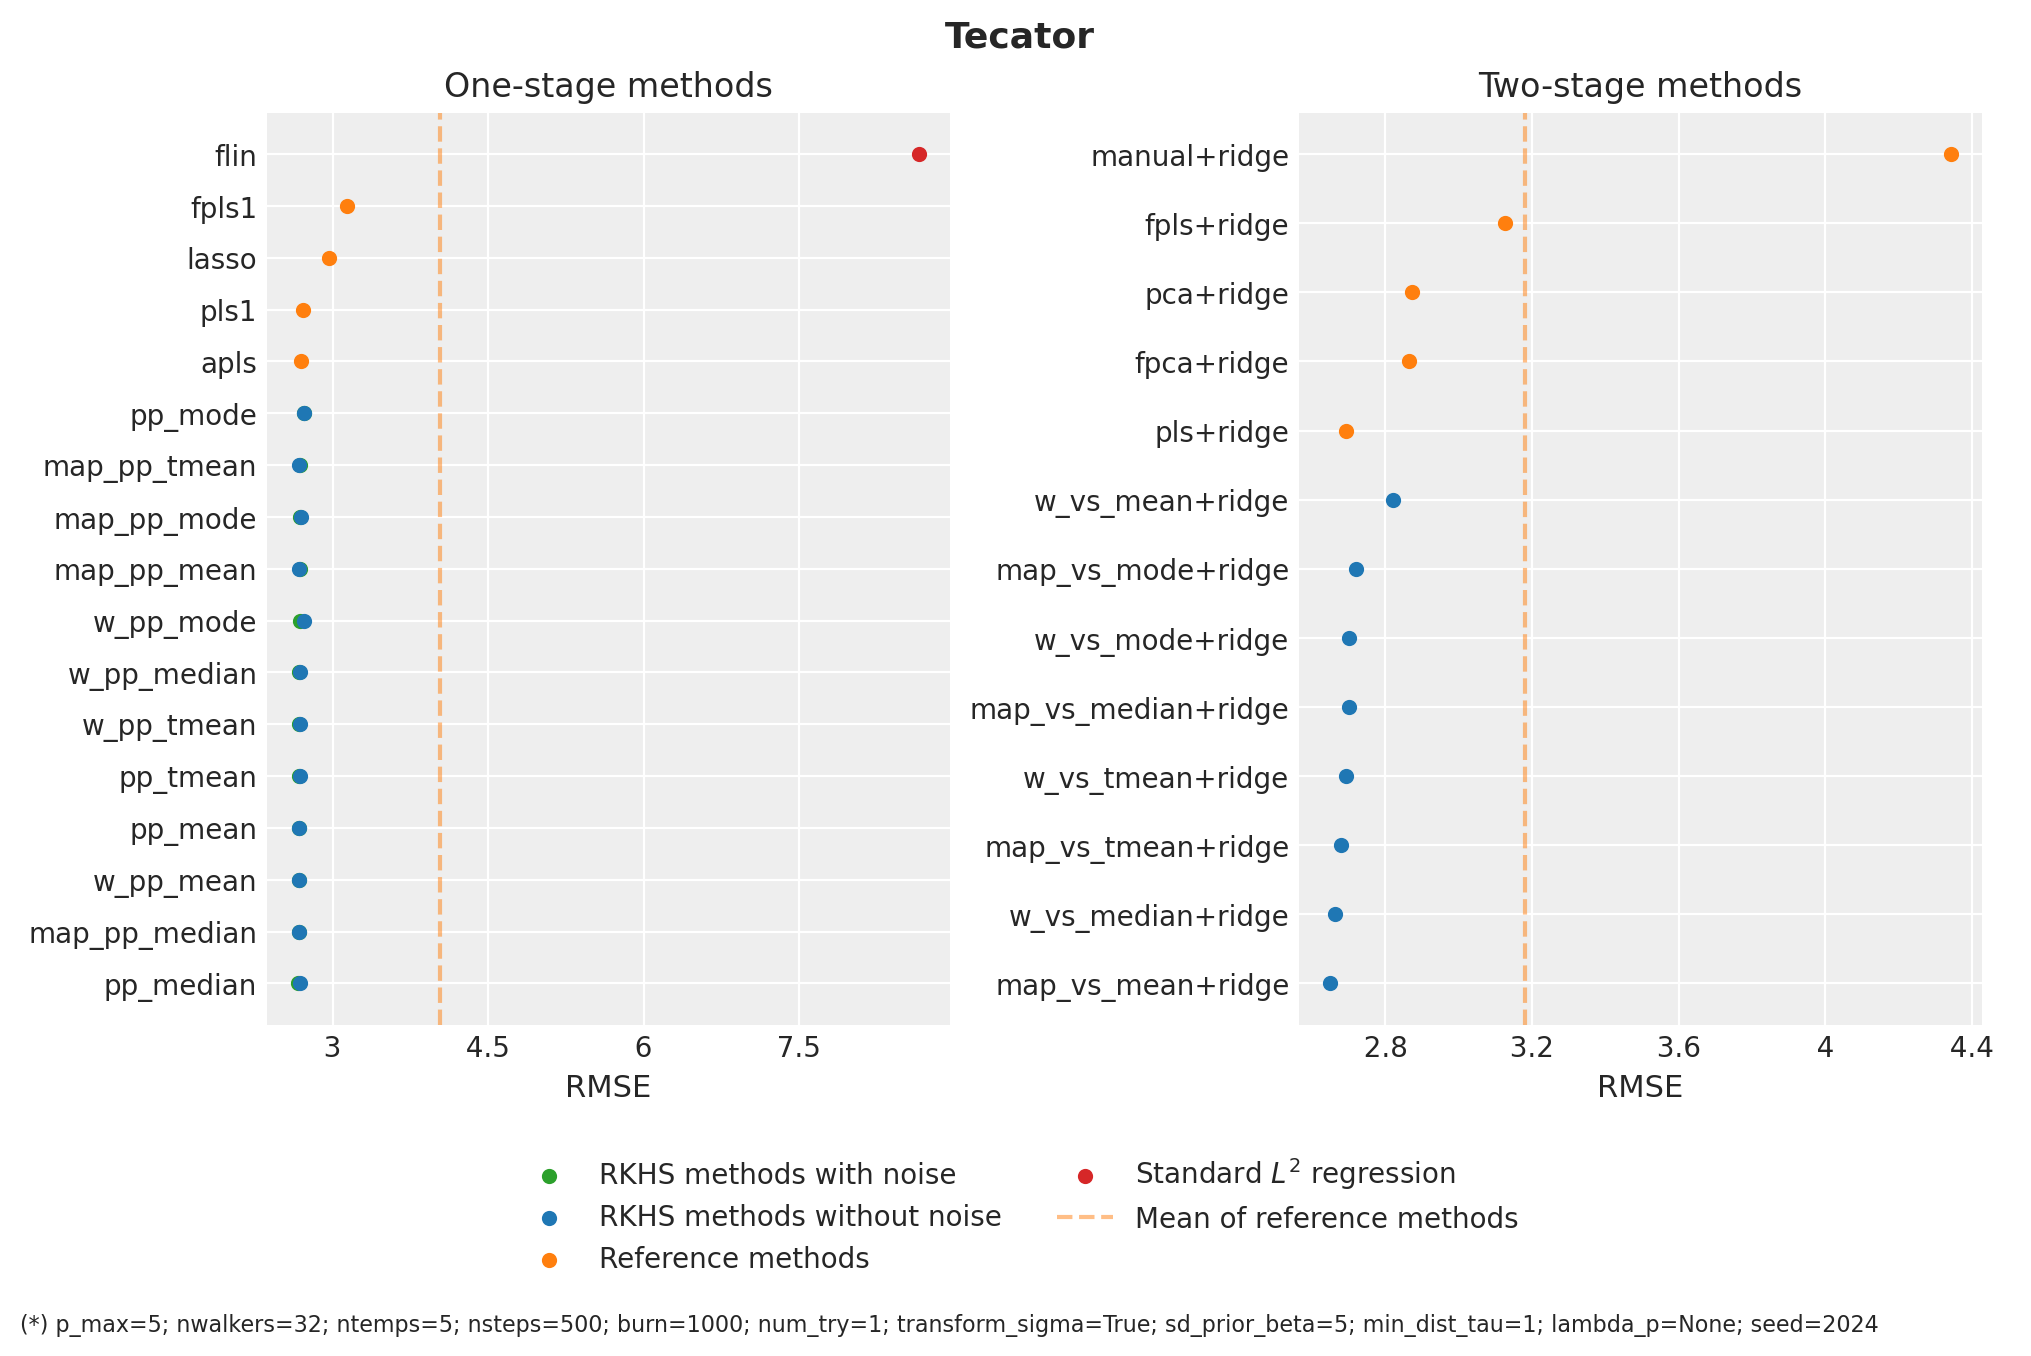

In [186]:
SAVE_FIG = False
ADD_SAMPLING_INFO = True
SHOW_REFERENCE_METHODS = True
SCORE_NAME = "RMSE"

if SYNTHETIC_DATA:
    title = f"{kernel_fn.__name__ if REGRESSOR_GEN == 'GP' else 'GBM'}+{MODEL_GEN}"
else:
    title = f"{REAL_DATA}"

fig = plot_utils.plot_prediction_results(
    df_all_methods_one,
    df_all_methods_two,
    df_reference_one if FIT_SK and SHOW_REFERENCE_METHODS else None,
    df_reference_two if FIT_SK and SHOW_REFERENCE_METHODS else None,
    title,
    score=SCORE_NAME
)

if ADD_SAMPLING_INFO:
    _ = fig.text(
        0,
        -0.2,
        f"(*) p_max={nleaves_max['components']}; nwalkers={nwalkers}; ntemps={ntemps}; "
        f"nsteps={nsteps}; burn={burn}; num_try={NUM_TRY if LAMBDA_P is None else 1}; transform_sigma={TRANSFORM_SIGMA}; "
        f"sd_prior_beta={SD_PRIOR_BETA}; min_dist_tau={MIN_DIST_TAU}; lambda_p={LAMBDA_P}; seed={SEED}",
        ha="left",
        fontsize=8,
    )

if SAVE_FIG:
    import datetime

    fig.savefig(
        f"results/figures/{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.pdf",
        bbox_inches="tight",
    )

### Save & load prediction scores

In [187]:
SAVE_PREDICTION_RESULTS = False

if SAVE_PREDICTION_RESULTS:
    if SYNTHETIC_DATA:
        filename = (
            f"{kernel_fn.__name__ if REGRESSOR_GEN == 'GP' else 'GBM'}+{MODEL_GEN}"
        )
    else:
        filename = f"{REAL_DATA}"

    if FIT_SK:
        df_comparison_all.to_csv(f"results/scores/{filename}_{SEED}.csv", index=False)
    else:
        df_all_methods.to_csv(f"results/scores/{filename}_{SEED}.csv", index=False)

In [188]:
LOAD_PREDICTION_RESULTS = False
FILENAME_LOAD = "results/scores/brownian_kernel+RKHS_2024.csv"

if LOAD_PREDICTION_RESULTS:
    df_all = pd.read_csv("results/scores/brownian_kernel+RKHS_2024.csv")
    df_all = df_all.drop_duplicates().fillna("N/A")
    display(df_all.style.hide(axis="index"))

## Command line experiments execution

In [100]:
!python experiments.py \
    linear l2 --kernel fbm \
    --seed 2024 \
    --nreps 2 \
    --nwalkers 32 --ntemps 5 --nleaves-max 5 \
    --nsteps 500 --nburn 1000 --num-try 2 \
    --sd-prior-beta 5 --lambda-p 3 \
    --verbose 0

*** Bayesian RKHS-based Functional Linear Regression with RJMCMC ***

-- GENERAL INFORMATION --
Random seed: 2024
Train/test splits: 2

-- DATASET GENERATION --
Total samples: 300
Train size: 200
Grid size: 100
X ~ GP(0, fractional_brownian_kernel)
Model type: L2

-- BAYESIAN RKHS MODEL --
Max. number of components (p): 5
Prior p: Poisson(3)
Prior beta: N(mu=0, sd=5)
Transform sigma: True
Min. distance tau: 1

-- ERYN SAMPLER --
Walkers: 32
Temps: 5
Burn: 1000
Steps: 500
Num try: 1

-- RESULTS REFERENCE METHODS --
Mean split execution time: 9.445±1.886 s
Total execution time: 0.315 min

   Estimator  Mean features  SD features  Mean RMSE  SD RMSE
manual+ridge            3.0          0.0     0.6039   0.0144
  fpls+ridge            3.0          2.0     0.6121   0.0109
   pca+ridge            1.0          0.0     0.6142   0.0111
  fpca+ridge            1.0          0.0     0.6146   0.0109
        flin            3.0          2.0     0.6160   0.0069
       fpls1            3.0          2.0

## Notebook metadata

In [189]:
%watermark -n -u -v -iv -w

Last updated: Wed May 01 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

matplotlib: 3.8.2
numpy     : 1.23.5
pandas    : 2.1.4

Watermark: 2.4.3

